In [2]:
# 开头导入必要的包
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import re 
import warnings
import math
import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.family'] = ['Microsoft YaHei']


In [ ]:
# 0627 将所有数据集合在一起训练，不归一化，汇报版本
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.optimize import minimize

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

def custom_model(x1, x2, C1, C2):
    """
    自定义模型函数 - 幂函数形式
    
    当前模型: Y = C1 * (x2/x1)^C2
    
    参数:
        x1: 换油率
        x2: 封存率  
        C1: 系数a
        C2: 系数b
        
    返回:
        预测值 Y
    """
    return C1 * (x2/x1)**C2
    

def get_model_description():
    """获取当前模型的描述"""
    return "Y = C1 * (x2/x1)^C2"

def get_feature_name():
    """获取当前模型使用的特征名称"""
    return "ratio_x2_x1"

def calculate_features(x1, x2):
    """
    根据当前模型计算特征
    
    参数:
        x1: 换油率
        x2: 封存率
        
    返回:
        特征值 (对应当前模型)
    """
    # 当前模型使用 x2/x1 作为特征
    return np.where(x1 != 0, x2 / x1, np.nan)

def process_raw_data(csv_file='数据结果_阈值_10.csv'):
    """处理原始数据（不归一化）"""
    
    print(f"\n📊 读取原始数据: {csv_file}...")
    # 尝试不同编码读取
    for encoding in ['utf-8-sig', 'gbk', 'utf-8', 'gb2312']:
        try:
            df = pd.read_csv(csv_file, encoding=encoding)
            print(f"成功读取数据，编码: {encoding}")
            break
        except:
            continue
    else:
        raise ValueError(f"无法读取数据文件: {csv_file}，请检查文件路径和编码")
    
    print(f"原始数据形状: {df.shape}")
    print(f"数据列名: {df.columns.tolist()}")
    
    # 使用原始换油率和封存率（不归一化）
    x1 = df['换油率'].copy()  # 换油率
    x2 = df['封存率'].copy()  # 封存率
    
    print(f"换油率范围: [{x1.min():.4f}, {x1.max():.4f}]")
    print(f"封存率范围: [{x2.min():.4f}, {x2.max():.4f}]")
    
    # 计算 diff = min(x1, x2) / abs(x1 - x2) 作为 Y
    numerator = np.minimum(x1, x2)  # min(x1, x2)
    denominator = np.abs(x1 - x2)   # abs(x1 - x2)
    
    # 避免除零错误
    Y = np.where(denominator != 0, numerator / denominator, np.nan)
    
    # 使用自定义模型计算特征
    ratio = calculate_features(x1, x2)
    feature_name = get_feature_name()
    
    # 创建新的数据框
    df_raw = pd.DataFrame({
        'x1_换油率': x1,
        'x2_封存率': x2,
        'Y_diff': Y,
        feature_name: ratio
    })
    
    # 去除无效值
    df_raw = df_raw.dropna()
    print(f"去除无效值后数据形状: {df_raw.shape}")
    
    # 处理无穷大值
    df_raw = df_raw.replace([np.inf, -np.inf], np.nan).dropna()
    print(f"去除无穷大值后数据形状: {df_raw.shape}")
    
    print(f"处理后数据统计:")
    print(f"  Y_diff范围: [{df_raw['Y_diff'].min():.4f}, {df_raw['Y_diff'].max():.4f}]")
    feature_name = get_feature_name()
    print(f"  {feature_name}范围: [{df_raw[feature_name].min():.4f}, {df_raw[feature_name].max():.4f}]")
    
    return df_raw

def clean_outliers(df_raw):
    """按原方法删除极值"""
    
    print("\n🧹 异常值清洗...")
    
    # 去除Y_diff > 99百分位数的数据
    Y_99 = df_raw['Y_diff'].quantile(0.99)
    mask1 = df_raw['Y_diff'] <= Y_99
    print(f"去除Y_diff > {Y_99:.3f}的数据: 移除{(~mask1).sum()}个")
    
    # 去除ratio的极端值（< 1% 或 > 99%）
    feature_name = get_feature_name()
    ratio_1 = df_raw[feature_name].quantile(0.01)
    ratio_99 = df_raw[feature_name].quantile(0.99)
    mask2 = (df_raw[feature_name] >= ratio_1) & (df_raw[feature_name] <= ratio_99)
    print(f"去除ratio < {ratio_1:.3f} 或 > {ratio_99:.3f}的数据: 移除{(~mask2).sum()}个")
    
    # 组合过滤
    final_mask = mask1 & mask2
    df_cleaned = df_raw[final_mask].copy()
    
    print(f"✨ 清洗后数据形状: {df_cleaned.shape}")
    print(f"移除数据比例: {(1 - len(df_cleaned)/len(df_raw)) * 100:.2f}%")
    
    return df_cleaned

def power_model_objective(params, x, y):
    """
    幂函数模型的损失函数
    
    参数:
        params: [a, b] 参数列表
        x: 特征值 (x2/x1)
        y: 目标值
        
    返回:
        均方误差
    """
    a, b = params
    y_pred = a * x**b
    return np.mean((y - y_pred)**2)

def train_raw_data_model(df_cleaned, train_size=0.8, seed=42):
    """训练原始数据模型（分割训练集和验证集）"""
    model_desc = get_model_description()
    print(f"\n🔄 数据集分割 (训练集{train_size*100:.0f}%, 验证集{(1-train_size)*100:.0f}%)...")
    print(f"🎯 当前模型: {model_desc}")

    feature_name = get_feature_name()
    X = df_cleaned[[feature_name]].values
    y = df_cleaned['Y_diff'].values

    # 数据集分割
    X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
        X, y, df_cleaned.index,
        train_size=train_size,
        random_state=seed,
        stratify=None
    )
    # 保证为numpy数组
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    print(f"训练集大小: {len(X_train)} 样本")
    print(f"验证集大小: {len(X_val)} 样本")

    # 拟合模型（只用训练集）
    X_train_flat = X_train.reshape(-1)
    result = minimize(
        power_model_objective,
        [1.0, 1.0],
        args=(X_train_flat, y_train),
        bounds=[(0, None), (0, None)],
        method='L-BFGS-B'
    )
    a, b = map(round, result.x)
    y_pred_train = a * X_train_flat**b
    y_pred_val = a * X_val.reshape(-1)**b

    r2_train = r2_score(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_val = r2_score(y_val, y_pred_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mse_val)

    print(f"📈 训练集结果:")
    print(f"幂函数方程: {model_desc.replace('C1', f'{a}').replace('C2', f'{b}')}")
    print(f"系数 a = {a}")
    print(f"指数 b = {b}")
    print(f"R² = {r2_train:.6f}")
    print(f"MSE = {mse_train:.6f}")
    print(f"RMSE = {rmse_train:.6f}")
    print(f"\n📈 验证集结果:")
    print(f"R² = {r2_val:.6f}")
    print(f"MSE = {mse_val:.6f}")
    print(f"RMSE = {rmse_val:.6f}")

    # 结果数据框
    df_train = df_cleaned.loc[idx_train].copy()
    df_val = df_cleaned.loc[idx_val].copy()
    df_train['Y_predicted'] = y_pred_train
    df_train['dataset'] = 'train'
    df_val['Y_predicted'] = y_pred_val
    df_val['dataset'] = 'validation'

    class PowerModel:
        def __init__(self, a, b):
            self.a = a
            self.b = b
        def predict(self, X):
            X_flat = X.reshape(-1)
            return self.a * X_flat**self.b
    model = PowerModel(a, b)

    return model, df_train, df_val, a, b, r2_train, r2_val, mse_train, mse_val, rmse_train, rmse_val

def process_baibao_raw_data(baibao_csv_file='Streamlit/data/HZP_归一化.csv', dataset_name='白豹'):
    """处理数据集原始数据"""
    
    print(f"\n📊 读取{dataset_name}原始数据: {baibao_csv_file}...")
    # 尝试不同编码读取
    for encoding in ['utf-8-sig', 'gbk', 'utf-8', 'gb2312']:
        try:
            df_baibao = pd.read_csv(baibao_csv_file, encoding=encoding)
            print(f"成功读取{dataset_name}数据集，编码: {encoding}")
            break
        except:
            continue
    else:
        raise ValueError(f"无法读取{dataset_name}数据集: {baibao_csv_file}，请检查文件路径和编码")
    
    print(f"{dataset_name}数据形状: {df_baibao.shape}")
    print(f"{dataset_name}数据列名: {df_baibao.columns.tolist()}")
    
    # 统一列名（防止编码问题）
    df_baibao.columns = ['x1_换油率', 'x2_封存率', '换油率归一化', '封存率归一化']
    
    # 使用原始换油率和封存率
    x1 = df_baibao['x1_换油率'].copy()
    x2 = df_baibao['x2_封存率'].copy()
    
    # 计算 Y = min(x1, x2) / abs(x1 - x2)
    numerator = np.minimum(x1, x2)
    denominator = np.abs(x1 - x2)
    Y = np.where(denominator != 0, numerator / denominator, np.nan)
    
    # 使用自定义模型计算特征
    ratio = calculate_features(x1, x2)
    feature_name = get_feature_name()
    
    # 创建数据框
    df_baibao_raw = pd.DataFrame({
        'x1_换油率': x1,
        'x2_封存率': x2,
        'Y_diff': Y,
        feature_name: ratio
    })
    
    # 去除无效值
    df_baibao_raw = df_baibao_raw.dropna()
    df_baibao_raw = df_baibao_raw.replace([np.inf, -np.inf], np.nan).dropna()
    
    # 去除Y_diff最大值的那个点
    if len(df_baibao_raw) > 0:
        max_y_idx = df_baibao_raw['Y_diff'].idxmax()
        max_y_value = df_baibao_raw.loc[max_y_idx, 'Y_diff']
        print(f"🗑️ 移除{dataset_name}数据中Y_diff最大值点: Y_diff = {max_y_value:.4f}")
        print(f"   对应的x1_换油率 = {df_baibao_raw.loc[max_y_idx, 'x1_换油率']:.4f}, x2_封存率 = {df_baibao_raw.loc[max_y_idx, 'x2_封存率']:.4f}")
        df_baibao_raw = df_baibao_raw.drop(max_y_idx)
    
    print(f"{dataset_name}原始数据处理后形状: {df_baibao_raw.shape}")
    print(f"{dataset_name}数据统计:")
    print(f"  Y_diff范围: [{df_baibao_raw['Y_diff'].min():.4f}, {df_baibao_raw['Y_diff'].max():.4f}]")
    feature_name = get_feature_name()
    print(f"  {feature_name}范围: [{df_baibao_raw[feature_name].min():.4f}, {df_baibao_raw[feature_name].max():.4f}]")
    
    return df_baibao_raw

def test_on_baibao(model, df_baibao_raw, dataset_name='白豹'):
    """在数据集上测试模型"""
    
    print(f"\n🎯 {dataset_name}数据集验证:")
    feature_name = get_feature_name()
    X_baibao = df_baibao_raw[[feature_name]].values
    y_baibao = df_baibao_raw['Y_diff'].values
    y_pred_baibao = model.predict(X_baibao)
    
    r2_baibao = r2_score(y_baibao, y_pred_baibao)
    mse_baibao = mean_squared_error(y_baibao, y_pred_baibao)
    rmse_baibao = np.sqrt(mse_baibao)
    
    print(f"R² = {r2_baibao:.6f}")
    print(f"MSE = {mse_baibao:.6f}")
    print(f"RMSE = {rmse_baibao:.6f}")
    
    df_baibao_raw['Y_predicted'] = y_pred_baibao
    df_baibao_raw['dataset'] = dataset_name
    
    return df_baibao_raw, r2_baibao, mse_baibao, rmse_baibao

def create_raw_data_plots(df_train, df_val, df_baibao, model, a, b, r2_train, r2_val, r2_baibao, output_prefix='原始数据分析结果', dataset_name='白豹'):
    """创建原始数据分析图表"""
    
    # 3面板图
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{output_prefix} (Y=a*(x2/x1)^b)', fontsize=18, fontweight='bold')
    
    # 子图1: 训练集
    axes[0].scatter(df_train['ratio_x2_x1'], df_train['Y_diff'], 
                   alpha=0.6, s=20, color='blue', label='训练集')
    
    # 绘制拟合线
    ratio_range = np.linspace(df_train['ratio_x2_x1'].min(), df_train['ratio_x2_x1'].max(), 100)
    y_line_train = a * ratio_range**b
    
    axes[0].plot(ratio_range, y_line_train, color='blue', linewidth=2, linestyle='-', 
                label=f'训练集拟合线')
    
    axes[0].set_xlabel('x2/x1 (封存率/换油率)', fontsize=14)
    axes[0].set_ylabel('Y = min(x1,x2)/abs(x1-x2)', fontsize=14)
    axes[0].set_title(f'训练集', fontsize=16)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # 子图2: 验证集
    axes[1].scatter(df_val['ratio_x2_x1'], df_val['Y_diff'], 
                   alpha=0.6, s=20, color='red', label='验证集')
    
    val_ratio_range = np.linspace(df_val['ratio_x2_x1'].min(), df_val['ratio_x2_x1'].max(), 100)
    y_line_val = a * val_ratio_range**b
    axes[1].plot(val_ratio_range, y_line_val, color='blue', linewidth=2, 
                label=f'训练集拟合线')
    
    axes[1].set_xlabel('x2/x1 (封存率/换油率)', fontsize=14)
    axes[1].set_ylabel('Y = min(x1,x2)/abs(x1-x2)', fontsize=14)
    axes[1].set_title(f'验证集', fontsize=16)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # 子图3: 数据集
    axes[2].scatter(df_baibao['ratio_x2_x1'], df_baibao['Y_diff'], 
                   alpha=0.7, s=30, color='green', label=f'{dataset_name}数据', marker='^')
    
    baibao_ratio_range = np.linspace(df_baibao['ratio_x2_x1'].min(), df_baibao['ratio_x2_x1'].max(), 100)
    y_line_baibao = a * baibao_ratio_range**b
    axes[2].plot(baibao_ratio_range, y_line_baibao, color='blue', linewidth=2, 
                label='训练集拟合线')
    
    axes[2].set_xlabel('x2/x1 (封存率/换油率)', fontsize=14)
    axes[2].set_ylabel('Y = min(x1,x2)/abs(x1-x2)', fontsize=14)
    axes[2].set_title(f'{dataset_name}数据', fontsize=16)
    axes[2].tick_params(axis='both', which='major', labelsize=12)
    axes[2].legend(fontsize=12)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plot_filename = f'{output_prefix}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return plot_filename

def save_raw_results(df_train, df_val, df_baibao, model_train, a, b, 
                    r2_train, r2_val, r2_baibao, mse_train, mse_val, mse_baibao,
                    rmse_train, rmse_val, rmse_baibao, output_prefix='原始数据'):
    """保存原始数据分析结果"""
    
    # 保存训练集结果
    output_columns = ['x1_换油率', 'x2_封存率', 'Y_diff', 'ratio_x2_x1', 'Y_predicted', 'dataset']
    
    df_train_output = df_train[output_columns].copy()
    filename_train = f'{output_prefix}_训练集结果.csv'
    df_train_output.to_csv(filename_train, index=False, encoding='utf-8-sig')
    print(f"\n💾 已保存训练集数据: {filename_train}")
    
    # 保存验证集结果
    df_val_output = df_val[output_columns].copy()
    filename_val = f'{output_prefix}_验证集结果.csv'
    df_val_output.to_csv(filename_val, index=False, encoding='utf-8-sig')
    print(f"💾 已保存验证集数据: {filename_val}")
    
    # 保存白豹数据集结果
    df_baibao_output = df_baibao[output_columns].copy()
    filename_baibao = f'{output_prefix}_白豹数据集结果.csv'
    df_baibao_output.to_csv(filename_baibao, index=False, encoding='utf-8-sig')
    print(f"💾 已保存白豹数据集: {filename_baibao}")
    
    # 保存模型参数和性能指标
    results_summary = {
        'dataset': ['训练集', '验证集', '白豹数据'],
        'samples': [len(df_train), len(df_val), len(df_baibao)],
        'coefficient_a': [a, a, a],
        'intercept_b': [b, b, b],
        'R_squared': [r2_train, r2_val, r2_baibao],
        'MSE': [mse_train, mse_val, mse_baibao],
        'RMSE': [rmse_train, rmse_val, rmse_baibao],
        'equation': [
            f'Y = {a:.6f} * (x2/x1) + {b:.6f}',
            f'Y = {a:.6f} * (x2/x1) + {b:.6f} (验证)',
            f'Y = {a:.6f} * (x2/x1) + {b:.6f} (白豹)'
        ]
    }
    
    df_summary = pd.DataFrame(results_summary)
    filename_summary = f'{output_prefix}_模型结果总结.csv'
    df_summary.to_csv(filename_summary, index=False, encoding='utf-8-sig')
    print(f"💾 已保存模型总结: {filename_summary}")

def test_custom_model(x1_test, x2_test, C1, C2):
    """
    测试自定义模型的预测效果
    
    参数:
        x1_test: 测试用的换油率值
        x2_test: 测试用的封存率值
        C1, C2: 模型系数
        
    返回:
        预测值
    """
    return custom_model(x1_test, x2_test, C1, C2)

def main(csv_file='Streamlit/data/test_0612', baibao_csv_file='Streamlit/data/HZP_归一化.csv', 
         output_prefix='原始数据', train_size=0.8, seed=42, dataset_name='HZP'):
    """
    主函数 - 执行原始数据分析
    """
    model_desc = get_model_description()
    print(f"🚀 开始原始数据分析 ({model_desc})...")
    print(f"📄 主数据文件: {csv_file}")
    print(f"📄 {dataset_name}数据文件: {baibao_csv_file}")
    print(f"📂 输出文件前缀: {output_prefix}")
    print(f"🎯 使用模型: {model_desc}")

    # 1. 处理原始数据
    df_raw = process_raw_data(csv_file)
    # 2. 清洗异常值
    df_cleaned = clean_outliers(df_raw)
    # 3. 训练模型
    model_train, df_train, df_val, a, b, r2_train, r2_val, mse_train, mse_val, rmse_train, rmse_val = train_raw_data_model(df_cleaned, train_size, seed)
    # 4. 处理数据集
    df_baibao_raw = process_baibao_raw_data(baibao_csv_file, dataset_name)
    # 5. 在数据集上测试
    df_baibao, r2_baibao, mse_baibao, rmse_baibao = test_on_baibao(model_train, df_baibao_raw, dataset_name)
    # 6. 创建图表
    plot_filename = create_raw_data_plots(df_train, df_val, df_baibao, model_train, a, b, r2_train, r2_val, r2_baibao, f'{output_prefix}_分析结果', dataset_name)
    # 7. 保存结果
    save_raw_results(df_train, df_val, df_baibao, model_train, a, b, 
                    r2_train, r2_val, r2_baibao, mse_train, mse_val, mse_baibao,
                    rmse_train, rmse_val, rmse_baibao, output_prefix)
    print(f"\n✅ 原始数据分析完成！")
    model_desc = get_model_description()
    final_equation = model_desc.replace('C1', f'{a:.6f}').replace('C2', f'{b:.6f}')
    print(f"📈 最终模型方程: {final_equation}")
    print(f"📊 系数 C1 = {a:.6f}")
    print(f"📊 截距 C2 = {b:.6f}")
    print(f"📈 训练集 R² = {r2_train:.6f}")
    print(f"📈 验证集 R² = {r2_val:.6f}")
    print(f"📈 {dataset_name}数据 R² = {r2_baibao:.6f}")
    print(f"📊 已生成图表: {plot_filename}")
    print(f"\n🔮 模型预测示例:")
    print(f"test_custom_model(x1=5.0, x2=0.8, C1={a:.6f}, C2={b:.6f}) = {test_custom_model(5.0, 0.8, a, b):.6f}")
    return df_train, df_val, df_baibao, model_train, a, b

# ============== 自定义模型使用说明 ==============
# 要修改模型形式，请编辑 custom_model 函数:
# 
# 1. 当前模型: Y = C1 * (x2/x1)^C2

# ============================================= 

def create_four_groups_data(csv_file='数据结果_阈值_10.csv'):
    """
    将原始数据分成四组：
    第一组：1-100行，401-500行（正韵律）
    第二组：101-200行，501-600行（反韵律）
    第三组：201-300行，601-675行（正反韵律）
    第四组：301-400行，675-end行（反正韵律）
    """
    
    print(f"\n📊 读取数据并分组: {csv_file}...")
    # 尝试不同编码读取
    for encoding in ['utf-8-sig', 'gbk', 'utf-8', 'gb2312']:
        try:
            df = pd.read_csv(csv_file, encoding=encoding)
            print(f"成功读取数据，编码: {encoding}")
            break
        except:
            continue
    else:
        raise ValueError(f"无法读取数据文件: {csv_file}，请检查文件路径和编码")
    
    print(f"原始数据形状: {df.shape}")
    
    # 使用原始换油率和封存率（不归一化）
    x1 = df['换油率'].copy()  # 换油率
    x2 = df['封存率'].copy()  # 封存率
    
    # 计算 diff = min(x1, x2) / abs(x1 - x2) 作为 Y
    numerator = np.minimum(x1, x2)  # min(x1, x2)
    denominator = np.abs(x1 - x2)   # abs(x1 - x2)
    
    # 避免除零错误
    Y = np.where(denominator != 0, numerator / denominator, np.nan)
    
    # 使用自定义模型计算特征
    ratio = calculate_features(x1, x2)
    feature_name = get_feature_name()
    
    # 创建新的数据框
    df_processed = pd.DataFrame({
        'x1_换油率': x1,
        'x2_封存率': x2,
        'Y_diff': Y,
        feature_name: ratio
    })
    
    # 去除无效值
    df_processed = df_processed.dropna()
    df_processed = df_processed.replace([np.inf, -np.inf], np.nan).dropna()
    
    # 定义四组的行索引范围（注意Python是0-based索引）
    group_definitions = {
        '正韵律': list(range(0, 100)) + list(range(400, 500)),  # 1-100行，401-500行
        '反韵律': list(range(100, 200)) + list(range(500, 600)),  # 101-200行，501-600行
        '正反韵律': list(range(200, 300)) + list(range(600, 675)),  # 201-300行，601-675行
        '反正韵律': list(range(300, 400)) + list(range(675, 750))  # 301-400行，675-end行
    }
    
    # 创建四组数据
    groups_data = {}
    for group_name, indices in group_definitions.items():
        # 确保索引不超出数据范围
        valid_indices = [i for i in indices if i < len(df_processed)]
        if valid_indices:
            group_df = df_processed.iloc[valid_indices].copy()
            group_df['group'] = group_name
            groups_data[group_name] = group_df
            print(f"{group_name}: {len(group_df)} 个样本")
        else:
            print(f"{group_name}: 0 个样本（索引超出范围）")
    
    return groups_data

def create_four_groups_plots(groups_data, model_train, a, b, output_prefix='四组分析结果'):
    """
    创建四个分组的图表，每个图显示一组数据和训练集拟合线
    """
    
    # 创建2x2的子图布局
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{output_prefix} - 四组数据分析', fontsize=18, fontweight='bold')
    
    # 展平axes数组以便迭代
    axes_flat = axes.flatten()
    
    # 定义颜色
    colors = ['purple', 'orange', 'brown', 'pink']
    
    # 为每组数据创建子图
    for idx, (group_name, group_df) in enumerate(groups_data.items()):
        if idx >= 4:  # 只处理前4组
            break
            
        ax = axes_flat[idx]
        color = colors[idx]
        
        if len(group_df) == 0:
            ax.text(0.5, 0.5, f'{group_name}\n无数据', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(group_name, fontsize=16)
            continue
        
        # 绘制该组的散点图
        ax.scatter(group_df['ratio_x2_x1'], group_df['Y_diff'], 
                  alpha=0.7, s=30, color=color, label=f'{group_name}数据')
        
        # 绘制训练集拟合线（蓝色线）
        if not group_df.empty:
            ratio_range = np.linspace(group_df['ratio_x2_x1'].min(), 
                                    group_df['ratio_x2_x1'].max(), 100)
            y_line = model_train.predict(ratio_range.reshape(-1, 1))
            
            ax.plot(ratio_range, y_line, color='blue', linewidth=2, linestyle='-', 
                   label=f'训练集拟合线')
        
        # 计算该组的R²
        if len(group_df) > 1:
            feature_name = get_feature_name()
            X_group = group_df[[feature_name]].values
            y_group = group_df['Y_diff'].values
            y_pred_group = model_train.predict(X_group)
            r2_group = r2_score(y_group, y_pred_group)
            
            # 只在控制台打印R²，不在图表标题中显示
            print(f"{group_name} R² = {r2_group:.6f}")
        else:
            r2_group = np.nan
            print(f"{group_name} R² = 无法计算（样本数不足）")
        
        ax.set_xlabel('x2/x1 (封存率/换油率)', fontsize=16)
        ax.set_ylabel('Y = min(x1,x2)/abs(x1-x2)', fontsize=16)
        ax.set_title(group_name, fontsize=14)  # 不显示R²
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_filename = f'{output_prefix}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return plot_filename

def save_four_groups_results(groups_data, model_train, a, b, output_prefix='四组数据'):
    """
    保存四组数据的分析结果
    """
    
    # 保存每组数据的详细结果
    for group_name, group_df in groups_data.items():
        if len(group_df) == 0:
            continue
            
        # 计算预测值
        feature_name = get_feature_name()
        X_group = group_df[[feature_name]].values
        y_pred_group = model_train.predict(X_group)
        
        group_df_output = group_df.copy()
        group_df_output['Y_predicted'] = y_pred_group
        
        # 保存该组数据
        filename_group = f'{output_prefix}_{group_name}_结果.csv'
        output_columns = ['x1_换油率', 'x2_封存率', 'Y_diff', 'ratio_x2_x1', 'Y_predicted', 'group']
        group_df_output[output_columns].to_csv(filename_group, index=False, encoding='utf-8-sig')
        print(f"💾 已保存{group_name}数据: {filename_group}")
    
    # 保存四组数据的性能总结
    summary_data = []
    for group_name, group_df in groups_data.items():
        if len(group_df) == 0:
            continue
            
        feature_name = get_feature_name()
        X_group = group_df[[feature_name]].values
        y_group = group_df['Y_diff'].values
        y_pred_group = model_train.predict(X_group)
        
        if len(group_df) > 1:
            r2_group = r2_score(y_group, y_pred_group)
            mse_group = mean_squared_error(y_group, y_pred_group)
            rmse_group = np.sqrt(mse_group)
        else:
            r2_group = np.nan
            mse_group = np.nan
            rmse_group = np.nan
        
        summary_data.append({
            'group': group_name,
            'samples': len(group_df),
            'coefficient_a': a,
            'intercept_b': b,
            'R_squared': r2_group,
            'MSE': mse_group,
            'RMSE': rmse_group,
            'equation': f'Y = {a:.6f} * (x2/x1) + {b:.6f}'
        })
    
    df_summary = pd.DataFrame(summary_data)
    filename_summary = f'{output_prefix}_四组性能总结.csv'
    df_summary.to_csv(filename_summary, index=False, encoding='utf-8-sig')
    print(f"💾 已保存四组性能总结: {filename_summary}")

def analyze_four_groups(csv_file='数据结果_阈值_10.csv', output_prefix='四组数据', seed=42):
    """
    主函数 - 执行四组数据分析
    
    参数:
        csv_file (str): 主数据文件路径，默认为'数据结果_阈值_10.csv'
        output_prefix (str): 输出文件前缀，默认为'四组数据'
        seed (int): 随机种子，用于训练集分割，默认为42
    
    返回:
        tuple: (groups_data, plot_filename)
    """
    
    print(f"\n🚀 开始四组数据分析...")
    print(f"📄 数据文件: {csv_file}")
    print(f"📂 输出前缀: {output_prefix}")
    print(f"🎲 随机种子: {seed}")
    
    # 首先需要获取训练好的模型（从main函数）
    print("\n🔄 先执行基础分析获取训练模型...")
    df_train, df_val, df_baibao, model_train, a, b = main(csv_file, seed=seed)
    
    # 1. 创建四组数据
    groups_data = create_four_groups_data(csv_file)
    
    # 2. 创建四个分组图表
    plot_filename = create_four_groups_plots(groups_data, model_train, a, b, f'{output_prefix}_分析结果')
    
    # 3. 保存四组数据结果
    save_four_groups_results(groups_data, model_train, a, b, output_prefix)
    
    print(f"\n✅ 四组数据分析完成！")
    print(f"📊 已生成四组分析图表: {plot_filename}")
    
    # 打印各组的R²到控制台
    print(f"\n📈 各组性能指标:")
    for group_name, group_df in groups_data.items():
        if len(group_df) > 1:
            feature_name = get_feature_name()
            X_group = group_df[[feature_name]].values
            y_group = group_df['Y_diff'].values
            y_pred_group = model_train.predict(X_group)
            r2_group = r2_score(y_group, y_pred_group)
            print(f"  {group_name}: R² = {r2_group:.6f} (样本数: {len(group_df)})")
        else:
            print(f"  {group_name}: 样本数不足，无法计算R² (样本数: {len(group_df)})")
    
    return groups_data, plot_filename

# ============== 使用示例 ==============
# 要执行分析，取消下面相应代码的注释：

if __name__ == "__main__":
    # 选择1: 只执行原始数据分析
    # df_train, df_val, df_baibao, model_train, a, b = main(
    #     csv_file='数据结果_阈值_10.csv',
    #     seed=60  # 可以修改seed值
    # )
    
    # 选择2: 执行四组数据分析（包含原始数据分析）
    groups_data, plot_filename = analyze_four_groups(
        # csv_file='数据结果_阈值_10.csv',
        # csv_file=r'D:\NEW_DATA\data\test_0612.csv',
        csv_file=r'D:\NEW_DATA\data\test_0620.csv',

        output_prefix='四组韵律分析',
        seed=60,  # 可以修改seed值来得到不同的训练集分割,
        # baibao_csv_file='Streamlit/data/BB_归一化.csv', 
        # dataset_name='白豹',



    )
    
    print(f"\n🎉 四组分析完成！")
    print(f"📊 生成的图表文件: {plot_filename}")
    
    # 显示各组的基本信息
    for group_name, group_df in groups_data.items():
        print(f"{group_name}: {len(group_df)} 个有效样本")
# ================================================

In [ ]:
# 敏感性分析
# 包含龙卷风图、敏感性指数计算和综合可视化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import re
import warnings
import math
import matplotlib.ticker as ticker
from typing import List, Union, Optional
warnings.filterwarnings("ignore")

yunlv = ['Pos', 'Neg', 'PosNeg', 'NegPos']

def extract_number(name):
    try:
        return int(name.split('_')[-1])
    except ValueError:
        try:
            return int(name.split('diff')[-1])
        except ValueError:
            for idx, value in enumerate(yunlv):
                if value in name.split('_'):
                    return idx
            return float('inf')

def get_attr(df_path, attr=None):
    df = pd.read_excel(df_path, header=None)
    attributes = []
    start_indices = []

    for i, row in df.iterrows():
        if not pd.isna(row[0]) and pd.isna(row[1:]).all():
            attributes.append(str(row[0]).split(',')[1].strip())
            start_indices.append(i)

    end_indices = start_indices[1:] + [len(df)]

    for idx, (attribute, start_idx, end_idx) in enumerate(zip(attributes, start_indices, end_indices)):
        if attribute == attr:
            data = df.iloc[start_idx+4:end_idx, :]
            data.columns = df.iloc[start_idx+1, :]
            try:
                data['X'] = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d %H:%M:%S')
            except:
                data['X'] = pd.to_datetime(data.iloc[:, 0], format='%Y/%m/%d')

            data_df = data.drop(columns=['X']).apply(pd.to_numeric, errors='coerce')
            yearly_data = pd.DataFrame()
            for year, group in data_df.groupby(data['X'].dt.year):
                group = group.dropna()
                yearly_data = pd.concat([yearly_data, group], ignore_index=True)
            return yearly_data
    return pd.DataFrame()

def get_case_names(df_path):
    df = pd.read_excel(df_path, header=None)
    return df.iloc[2, 1:].dropna().tolist()

def calculate_npv(cash_flows, discount_rate=0.1, periods_per_year=1):
    npv = 0
    for i, cash in enumerate(cash_flows):
        time_in_years = i / periods_per_year
        npv += cash / ((1 + discount_rate) ** time_in_years)
    return npv

def heaviside(x):
    return np.where(x < 0, 0, 1)

def cal_npv_from_excel(df_path: str, 
                      ro: Union[float, List[float]] = 3173, r_CO2_i: float = 1.2, r_W_i: float = 20.6, 
                      r_re_CO2: float = 0.15, r_CO2: float = 0.65, r_re_W: float = 1.5, 
                      TAX_CO2: Union[float, List[float]] = 0.114, SUB_CO2: float = 0.114, 
                      TRADE_CO2: Union[float, List[float]] = 0.182, Limit2: float = 900000, 
                      x_labels: Optional[List[str]] = None, x_axis_name: str = '方案编号',
                      OIP: float = 725595):
    """计算NPV，不进行绘图，返回NPV值列表"""
    
    # 获取所有数据
    opc = get_attr(df_path, 'Oil production cumulative')
    gic = get_attr(df_path, 'Gas injection cumulative')
    gpc = get_attr(df_path, 'Gas production cumulative')
    wic = get_attr(df_path, 'Water injection cumulative')
    wpc = get_attr(df_path, 'Water production cumulative')
    ore = get_attr(df_path, 'Oil recovery efficiency')
    tic = get_attr(df_path, 'Tracer injection cumulative')
    co2_prod = get_attr(df_path, 'Tracer production cumulative')
    oil_dens = get_attr(df_path, 'Oil density')
    gas_dens = get_attr(df_path, 'Gas density')
    gas_mass_inj = get_attr(df_path, 'Gas mass injection cumulative')
    oil_mass_prod = get_attr(df_path, 'Oil mass production cumulative')

    if opc.empty or gic.empty or gpc.empty or tic.empty or co2_prod.empty:
        raise ValueError("某些必要的数据为空，请检查Excel文件中的数据")

    if ore.empty:
        ore = opc / OIP

    data_shapes = {
        'opc': opc.shape[1], 'gic': gic.shape[1], 'gpc': gpc.shape[1],
        'ore': ore.shape[1], 'tic': tic.shape[1], 'co2_prod': co2_prod.shape[1]
    }
    
    if len(set(data_shapes.values())) > 1:
        print("警告：数据列数不一致：")
        for name, shape in data_shapes.items():
            print(f"{name}: {shape}列")
        raise ValueError("所有数据集的列数必须相同")

    if wic.empty:
        wic = opc * 0
    if wpc.empty:
        wpc = opc * 0
    
    df = pd.read_excel(df_path, header=None)
    legends = df.iloc[2, 1:].dropna().tolist()
    sorted_legends = sorted(legends, key=extract_number)
    sorted_indices = [legends.index(legend) for legend in sorted_legends]
    
    max_index = max(data_shapes.values()) - 1
    if any(idx > max_index for idx in sorted_indices):
        print(f"警告：索引超出范围。最大索引应为{max_index}，但存在更大的索引")
        raise ValueError("索引超出数据范围")

    # 对所有数据进行排序
    opc = opc.iloc[:, sorted_indices]
    gic = gic.iloc[:, sorted_indices]
    wic = wic.iloc[:, sorted_indices]
    wpc = wpc.iloc[:, sorted_indices]
    co2_prod = co2_prod.iloc[:, sorted_indices]
    ore = ore.iloc[:, sorted_indices]
    tic = tic.iloc[:, sorted_indices]

    # 处理密度数据
    if oil_dens.empty:
        oil_dens = pd.DataFrame(867, index=opc.index, columns=opc.columns)
    else:
        oil_dens = oil_dens.iloc[:, sorted_indices]

    if gas_dens.empty:
        gas_dens = pd.DataFrame(1.98, index=opc.index, columns=opc.columns)
    else:
        gas_dens = gas_dens.iloc[:, sorted_indices]

    if gas_mass_inj.empty:
        gas_mass_inj = pd.DataFrame(0, index=opc.index, columns=opc.columns)
    else:
        gas_mass_inj = gas_mass_inj.iloc[:, sorted_indices]

    if oil_mass_prod.empty:
        oil_mass_prod = pd.DataFrame(0, index=opc.index, columns=opc.columns)
    else:
        oil_mass_prod = oil_mass_prod.iloc[:, sorted_indices]

    # 减去第一个值
    opc = opc - opc.iloc[0]
    gic = gic - gic.iloc[0]
    wic = wic - wic.iloc[0]
    wpc = wpc - wpc.iloc[0]
    co2_prod = co2_prod - co2_prod.iloc[0]

    co2_store = gic - co2_prod
    case_names = get_case_names(df_path)
    
    if x_labels is None:
        x_labels = [str(i) for i in range(1, len(case_names) + 1)]
    
    if len(x_labels) != len(case_names):
        print(f"警告：x_labels长度({len(x_labels)})与案例数量({len(case_names)})不匹配，将使用默认编号")
        x_labels = [str(i) for i in range(1, len(case_names) + 1)]

    # 计算NPV
    npv_values = []
    
    for column in opc.columns:
        qt_o_delta = opc[column].diff().fillna(opc[column].iloc[0])
        qt_CO2_i_delta = gic[column].diff().fillna(gic[column].iloc[0])
        qt_W_i_delta = wic[column].diff().fillna(wic[column].iloc[0])
        qt_CO2_p_delta = co2_prod[column].diff().fillna(co2_prod[column].iloc[0])
        qt_W_p_delta = wpc[column].diff().fillna(wpc[column].iloc[0])
        Vt_CCS_delta = co2_store[column].diff().fillna(co2_store[column].iloc[0])
        GPC_delta = gpc[column].diff().fillna(gpc[column].iloc[0])

        cash_flows = (qt_o_delta * ro - 
                     qt_CO2_i_delta * r_CO2_i - 
                     qt_W_i_delta * r_W_i - 
                     qt_CO2_p_delta * r_re_CO2 + 
                     qt_CO2_p_delta * r_CO2 - 
                     qt_W_p_delta * r_re_W + 
                     Vt_CCS_delta * SUB_CO2 - 
                     GPC_delta * TAX_CO2 + 
                     (qt_CO2_p_delta - Limit2) * TRADE_CO2)  / 10000000
        
        npv_values.append(calculate_npv(cash_flows))

    return npv_values, x_labels

def generate_sensitivity_values(base_value: float) -> List[float]:
    """生成敏感性分析的七个值：除以2、1.5、1.2，基础值，乘以1.2、1.5、2"""
    return [
        base_value / 2,
        base_value / 1.5,
        base_value / 1.2,
        base_value,
        base_value * 1.2,
        base_value * 1.5,
        base_value * 2
    ]

def sensitivity_analysis(df_path: str, output_csv: str):
    """进行敏感性分析"""
    # 基础参数值
    base_params = {
        'ro': 3144,
        'r_CO2_i': 1.2,
        'r_W_i': 20.6,
        'r_re_W': 1.5,
        'r_CO2': 0.65,
        'r_re_CO2': 0.15,
        'TAX_CO2': 0.14,
        'SUB_CO2': 0.114,
        'TRADE_CO2': 0.182
    }
    
    # 生成敏感性分析的参数值
    sensitivity_params = {}
    print("敏感性分析参数值：")
    for param, base_value in base_params.items():
        values = generate_sensitivity_values(base_value)
        sensitivity_params[param] = values
        print(f"{param}: {values}")
    
    # 获取基础NPV计算结果
    base_npv, x_labels = cal_npv_from_excel(df_path, x_labels=['10t/d', '15t/d','20t/d', '25t/d'])
    
    # 存储所有敏感性分析结果
    sensitivity_results = {}
    
    # 为每个参数进行敏感性分析
    for param_name, param_values in sensitivity_params.items():
        param_npv_results = []
        
        for i, value in enumerate(param_values):
            # 设置基础参数
            kwargs = {
                'ro': base_params['ro'],
                'r_CO2_i': base_params['r_CO2_i'],
                'r_W_i': base_params['r_W_i'],
                'r_re_W': base_params['r_re_W'],
                'r_CO2': base_params['r_CO2'],
                'r_re_CO2': base_params['r_re_CO2'],
                'TAX_CO2': base_params['TAX_CO2'],
                'SUB_CO2': base_params['SUB_CO2'],
                'TRADE_CO2': base_params['TRADE_CO2']
            }
            
            # 修改当前参数
            kwargs[param_name] = value
            
            # 计算NPV
            npv_values, _ = cal_npv_from_excel(df_path, x_labels=['10t/d', '15t/d','20t/d', '25t/d'], **kwargs)
            param_npv_results.append(npv_values)
        
        # 存储结果
        for i, case_label in enumerate(x_labels):
            for j, value in enumerate(param_values):
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                sensitivity_results[col_name] = param_npv_results[j][i]
    
    # 转换为DataFrame并保存
    results_df = pd.DataFrame([sensitivity_results])
    results_df.to_csv(output_csv, index=False)
    print(f"敏感性分析结果已保存到: {output_csv}")
    
    return sensitivity_results, x_labels, sensitivity_params

def calculate_sensitivity_index(sensitivity_results: dict, x_labels: List[str], sensitivity_params: dict):
    """计算敏感性指数"""
    sensitivity_indices = {}
    
    for param_name, param_values in sensitivity_params.items():
        total_variance = 0
        case_count = 0
        
        for case_label in x_labels:
            case_npv_values = []
            for value in param_values:
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                case_npv_values.append(sensitivity_results[col_name])
            
            # 计算该案例下该参数的变异系数
            mean_npv = np.mean(case_npv_values)
            std_npv = np.std(case_npv_values)
            if abs(mean_npv) > 1e-6:  # 避免除零
                cv = abs(std_npv / mean_npv)
                total_variance += cv
                case_count += 1
        
        # 平均变异系数作为敏感性指数
        sensitivity_indices[param_name] = total_variance / case_count if case_count > 0 else 0
    
    return sensitivity_indices

def plot_comprehensive_sensitivity(sensitivity_results: dict, x_labels: List[str], sensitivity_params: dict):
    """绘制综合敏感性分析图"""
    import os
    
    # 创建PNG文件夹
    png_folder = 'PNG'
    if not os.path.exists(png_folder):
        os.makedirs(png_folder)
    
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 参数名称中文化
    param_names_cn = {
        'ro': '原油价格',
        'r_CO2_i': 'CO2注入成本',
        'r_W_i': '注水成本', 
        'r_re_W': '产水处理成本',
        'r_CO2': 'CO2生产收益',
        'r_re_CO2': 'CO2回收成本',
        'TAX_CO2': '碳税',
        'SUB_CO2': 'CCS补贴',
        'TRADE_CO2': '碳交易价格'
    }
    
    import matplotlib.cm as cm
    colors = cm.tab10(np.linspace(0, 1, len(sensitivity_params)))
    
    # 计算敏感性指数用于后续图表
    sensitivity_indices = calculate_sensitivity_index(sensitivity_results, x_labels, sensitivity_params)
    sorted_indices = sorted(sensitivity_indices.items(), key=lambda x: x[1], reverse=True)
    
    # 计算参数敏感性范围
    param_sensitivity = {}
    for param_name, param_values in sensitivity_params.items():
        min_npv = float('inf')
        max_npv = float('-inf')
        
        for case_label in x_labels:
            case_npv_values = []
            for value in param_values:
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                case_npv_values.append(sensitivity_results[col_name])
            
            min_npv = min(min_npv, min(case_npv_values))
            max_npv = max(max_npv, max(case_npv_values))
        
        param_sensitivity[param_name] = max_npv - min_npv
    
    sorted_params = sorted(param_sensitivity.items(), key=lambda x: x[1], reverse=True)
    
    # 图1: 各参数NPV变化范围的填充图
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    
    for i, (param_name, param_values) in enumerate(sensitivity_params.items()):
        param_npv_data = []
        for case_idx, case_label in enumerate(x_labels):
            case_npv_values = []
            for value in param_values:
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                case_npv_values.append(sensitivity_results[col_name])
            param_npv_data.append(case_npv_values)
        
        param_npv_data = np.array(param_npv_data)
        mean_values = np.mean(param_npv_data, axis=1)
        max_values = np.max(param_npv_data, axis=1)
        min_values = np.min(param_npv_data, axis=1)
        
        x_pos = np.arange(len(x_labels))
        
        ax1.fill_between(x_pos, min_values, max_values, color=colors[i], alpha=0.3)
        ax1.plot(x_pos, mean_values, color=colors[i], linewidth=4, marker='o', markersize=10,
                label=param_names_cn.get(param_name, param_name))
    
    ax1.set_xlabel('注气速率', fontsize=20, fontweight='bold')
    ax1.set_ylabel('NPV (千万元)', fontsize=20, fontweight='bold')
    ax1.set_title('各参数NPV变化范围', fontsize=24, fontweight='bold', pad=30)
    ax1.set_xticks(range(len(x_labels)))
    ax1.set_xticklabels(x_labels, fontsize=18)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig1.savefig(os.path.join(png_folder, '1_参数NPV变化范围.png'), dpi=300, bbox_inches='tight')
    plt.close(fig1)
    
    # 图2: 敏感性指数条形图  
    fig2, ax2 = plt.subplots(figsize=(14, 10))
    
    param_names = [param_names_cn.get(param, param) for param, _ in sorted_indices]
    indices_values = [value for _, value in sorted_indices]
    
    bars = ax2.bar(range(len(param_names)), indices_values, color=colors[:len(param_names)], alpha=0.8)
    ax2.set_xlabel('参数', fontsize=20, fontweight='bold')
    ax2.set_ylabel('敏感性指数', fontsize=20, fontweight='bold')
    ax2.set_title('敏感性指数排序', fontsize=24, fontweight='bold', pad=30)
    ax2.set_xticks(range(len(param_names)))
    ax2.set_xticklabels(param_names, rotation=45, ha='right', fontsize=16)
    ax2.tick_params(axis='y', labelsize=18)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 在条形图上添加数值标签
    for bar, value in zip(bars, indices_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(indices_values) * 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    fig2.savefig(os.path.join(png_folder, '2_敏感性指数排序.png'), dpi=300, bbox_inches='tight')
    plt.close(fig2)
    
    # 图3: 最敏感参数的详细分析
    fig3, ax3 = plt.subplots(figsize=(14, 10))
    
    top3_params = sorted_indices[:1]  # 只取最敏感的参数
    
    for i, (param_name, _) in enumerate(top3_params):
        param_values = sensitivity_params[param_name]
        
        for j, (case_idx, case_label) in enumerate(enumerate(x_labels)):
            case_npv_values = []
            for k, value in enumerate(param_values):
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                case_npv_values.append(sensitivity_results[col_name])
            
            ax3.plot(param_values, case_npv_values, marker='o', linewidth=4, markersize=10,
                    label=f'{case_label}', color=colors[j])
    
    param_name_cn = param_names_cn.get(top3_params[0][0], top3_params[0][0])
    ax3.set_xlabel(f'{param_name_cn} 值', fontsize=20, fontweight='bold')
    ax3.set_ylabel('NPV (千万元)', fontsize=20, fontweight='bold')
    ax3.set_title(f'最敏感参数详细分析: {param_name_cn}', fontsize=24, fontweight='bold', pad=30)
    ax3.tick_params(axis='both', labelsize=18)
    ax3.legend(fontsize=16)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig3.savefig(os.path.join(png_folder, '3_最敏感参数详细分析.png'), dpi=300, bbox_inches='tight')
    plt.close(fig3)
    
    # 图4: 龙卷风图风格的敏感性对比
    fig4, ax4 = plt.subplots(figsize=(14, 12))
    
    # 确保从大到小排序（reversed for display）
    param_names = [param_names_cn.get(param, param) for param, _ in reversed(sorted_params)]
    ranges = [value for _, value in reversed(sorted_params)]
    
    # 创建渐变色
    colors_gradient = cm.viridis(np.linspace(0.2, 0.9, len(param_names)))
    
    bars = ax4.barh(range(len(param_names)), ranges, color=colors_gradient, alpha=0.8, height=0.7)
    ax4.set_xlabel('NPV变化范围 (千万元)', fontsize=20, fontweight='bold')
    ax4.set_ylabel('参数', fontsize=20, fontweight='bold')
    ax4.set_title('参数敏感性排序（龙卷风图风格）', fontsize=24, fontweight='bold', pad=30)
    ax4.set_yticks(range(len(param_names)))
    ax4.set_yticklabels(param_names, fontsize=16)
    ax4.tick_params(axis='x', labelsize=18)
    ax4.grid(True, alpha=0.3, axis='x')
    
    # 在条形图上添加数值标签
    for bar, value in zip(bars, ranges):
        width = bar.get_width()
        ax4.text(width + max(ranges) * 0.01, bar.get_y() + bar.get_height()/2.,
                f'{value:.2f}', ha='left', va='center', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    fig4.savefig(os.path.join(png_folder, '4_龙卷风图敏感性对比.png'), dpi=300, bbox_inches='tight')
    plt.close(fig4)
    
    # 创建综合图表（四合一）
    fig_combined, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(28, 22))
    
    # 重新绘制所有图表到综合图中（字号适中但清晰）
    # 图1
    for i, (param_name, param_values) in enumerate(sensitivity_params.items()):
        param_npv_data = []
        for case_idx, case_label in enumerate(x_labels):
            case_npv_values = []
            for value in param_values:
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                case_npv_values.append(sensitivity_results[col_name])
            param_npv_data.append(case_npv_values)
        
        param_npv_data = np.array(param_npv_data)
        mean_values = np.mean(param_npv_data, axis=1)
        max_values = np.max(param_npv_data, axis=1)
        min_values = np.min(param_npv_data, axis=1)
        
        x_pos = np.arange(len(x_labels))
        
        ax1.fill_between(x_pos, min_values, max_values, color=colors[i], alpha=0.3)
        ax1.plot(x_pos, mean_values, color=colors[i], linewidth=3, marker='o', markersize=8,
                label=param_names_cn.get(param_name, param_name))
    
    ax1.set_xlabel('注气速率', fontsize=18, fontweight='bold')
    ax1.set_ylabel('NPV (千万元)', fontsize=18, fontweight='bold')
    ax1.set_title('各参数NPV变化范围', fontsize=20, fontweight='bold')
    ax1.set_xticks(range(len(x_labels)))
    ax1.set_xticklabels(x_labels, fontsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # 图2
    param_names = [param_names_cn.get(param, param) for param, _ in sorted_indices]
    indices_values = [value for _, value in sorted_indices]
    
    bars = ax2.bar(range(len(param_names)), indices_values, color=colors[:len(param_names)])
    ax2.set_xlabel('参数', fontsize=18, fontweight='bold')
    ax2.set_ylabel('敏感性指数', fontsize=18, fontweight='bold')
    ax2.set_title('敏感性指数排序', fontsize=20, fontweight='bold')
    ax2.set_xticks(range(len(param_names)))
    ax2.set_xticklabels(param_names, rotation=45, ha='right', fontsize=14)
    ax2.tick_params(axis='y', labelsize=16)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars, indices_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{value:.3f}', ha='center', va='bottom', fontsize=14)
    
    # 图3
    top3_params = sorted_indices[:1]
    
    for i, (param_name, _) in enumerate(top3_params):
        param_values = sensitivity_params[param_name]
        
        for j, (case_idx, case_label) in enumerate(enumerate(x_labels)):
            case_npv_values = []
            for k, value in enumerate(param_values):
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                case_npv_values.append(sensitivity_results[col_name])
            
            ax3.plot(param_values, case_npv_values, marker='o', linewidth=3, markersize=8,
                    label=f'{case_label}', color=colors[j])
    
    param_name_cn = param_names_cn.get(top3_params[0][0], top3_params[0][0])
    ax3.set_xlabel(f'{param_name_cn} 值', fontsize=18, fontweight='bold')
    ax3.set_ylabel('NPV (千万元)', fontsize=18, fontweight='bold')
    ax3.set_title(f'最敏感参数详细分析: {param_name_cn}', fontsize=20, fontweight='bold')
    ax3.tick_params(axis='both', labelsize=16)
    ax3.legend(fontsize=15)
    ax3.grid(True, alpha=0.3)
    
    # 图4 - 确保从大到小排序
    param_names = [param_names_cn.get(param, param) for param, _ in reversed(sorted_params)]
    ranges = [value for _, value in reversed(sorted_params)]
    
    bars = ax4.barh(range(len(param_names)), ranges, color=colors[:len(param_names)])
    ax4.set_xlabel('NPV变化范围 (千万元)', fontsize=18, fontweight='bold')
    ax4.set_ylabel('参数', fontsize=18, fontweight='bold')
    ax4.set_title('参数敏感性排序（龙卷风图风格）', fontsize=20, fontweight='bold')
    ax4.set_yticks(range(len(param_names)))
    ax4.set_yticklabels(param_names, fontsize=15)
    ax4.tick_params(axis='x', labelsize=16)
    ax4.grid(True, alpha=0.3, axis='x')
    
    for bar, value in zip(bars, ranges):
        width = bar.get_width()
        ax4.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
                f'{value:.2f}', ha='left', va='center', fontsize=14)
    
    plt.tight_layout()
    fig_combined.savefig(os.path.join(png_folder, '综合敏感性分析图.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ 图表已保存到 {png_folder} 文件夹：")
    print("  📊 1_参数NPV变化范围.png")
    print("  📊 2_敏感性指数排序.png") 
    print("  📊 3_最敏感参数详细分析.png")
    print("  📊 4_龙卷风图敏感性对比.png")
    print("  📊 综合敏感性分析图.png")
    
    # 打印敏感性分析摘要
    print("\n=== 敏感性分析摘要 ===")
    print("敏感性指数排序（变异系数）：")
    for i, (param, index) in enumerate(sorted_indices, 1):
        param_cn = param_names_cn.get(param, param)
        print(f"{i}. {param_cn}: {index:.4f}")
    
    print("\nNPV变化范围排序：")
    for i, (param, range_val) in enumerate(sorted_params, 1):
        param_cn = param_names_cn.get(param, param)
        print(f"{i}. {param_cn}: {range_val:.2f} 千万元")
    
    return sensitivity_indices, param_sensitivity

def export_sensitivity_index_process(sensitivity_results, x_labels, sensitivity_params, output_csv='敏感性指数计算过程.csv'):
    import numpy as np
    import pandas as pd
    rows = []
    for param_name, param_values in sensitivity_params.items():
        cvs = []
        for case_label in x_labels:
            npv_list = []
            for value in param_values:
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                npv_list.append(sensitivity_results[col_name])
            mean_npv = np.mean(npv_list)
            std_npv = np.std(npv_list)
            cv = abs(std_npv / mean_npv) if abs(mean_npv) > 1e-6 else 0
            cvs.append(cv)
            rows.append({
                '参数': param_name,
                '方案': case_label,
                '参数取值': ','.join([f'{v:.3f}' for v in param_values]),
                'NPV序列': ','.join([f'{n:.6f}' for n in npv_list]),
                '均值': mean_npv,
                '标准差': std_npv,
                '变异系数': cv
            })
        # 该参数的敏感性指数（所有方案变异系数的平均）
        rows.append({
            '参数': param_name,
            '方案': '平均',
            '参数取值': '',
            'NPV序列': '',
            '均值': '',
            '标准差': '',
            '变异系数': np.mean(cvs)
        })
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False, encoding='gbk')
    print(f'敏感性指数计算过程已保存为：{output_csv}')

# 运行敏感性分析
if __name__ == "__main__":
    df_path = r'D:\NEW_DATA\data\BB\Plotting_CO2T_resample.xlsx'
    output_csv = 'sensitivity_analysis_results.csv'
    
    # 执行敏感性分析
    sensitivity_results, x_labels, sensitivity_params = sensitivity_analysis(df_path, output_csv)
    
    # 绘制综合敏感性分析图
    sensitivity_indices, param_sensitivity = plot_comprehensive_sensitivity(sensitivity_results, x_labels, sensitivity_params)
    
    # 创建整理好的CSV文件
    organized_data = []
    param_names_cn = {
        'ro': '原油价格(元/m³)',
        'r_CO2_i': 'CO2注入成本(元/m³)',
        'r_W_i': '注水成本(元/m³)', 
        'r_re_W': '产水处理成本(元/m³)',
        'r_CO2': 'CO2生产收益(元/m³)',
        'r_re_CO2': 'CO2回收成本(元/m³)',
        'TAX_CO2': '碳税(元/m³)',
        'SUB_CO2': 'CCS补贴(元/m³)',
        'TRADE_CO2': '碳交易价格(元/m³)'
    }
    
    for param_name, param_values in sensitivity_params.items():
        for i, value in enumerate(param_values):
            for j, case_label in enumerate(x_labels):
                col_name = f"{param_name}_{value:.3f}_{case_label}"
                organized_data.append({
                    '参数名称': param_names_cn.get(param_name, param_name),
                    '参数英文名': param_name,
                    '参数值': value,
                    '参数变化倍数': ['÷2', '÷1.5', '÷1.2', '基准', '×1.2', '×1.5', '×2'][i],
                    '案例': case_label,
                    'NPV(千万元)': sensitivity_results[col_name],
                    '敏感性指数': sensitivity_indices[param_name],
                    'NPV变化范围': param_sensitivity[param_name]
                })
    
    organized_df = pd.DataFrame(organized_data)
    organized_csv = 'sensitivity_analysis_organized.csv'
    organized_df.to_csv(organized_csv, index=False, encoding='utf-8-sig')
    print(f"\n整理后的敏感性分析结果已保存到: {organized_csv}") 

    # 导出敏感性指数计算过程
    export_sensitivity_index_process(sensitivity_results, x_labels, sensitivity_params) 

In [ ]:
# 0627 导出机理模型的采收率/封存率
# 0528 换油率=累产油/累计注气（t/t）
# 0428 导出的出图模板，变成两列（换油率，封存率）
# V5 增油换油率（累产油-水驱最大累产油） / 注入的CO2量  (sm3) 
# V4 封存率+采收率

identifier_dict = {
    "Field": "全油田"
}

def export_rates(df_path, WINJ_OPC_MAX=0, tracer_inj_cum = 0, oil_cum = 0):
    df = pd.read_excel(df_path, header=None)
    # 自定义图例
    legends = df.iloc[2, 1:].dropna().tolist()
  
    # 初始化变量
    attributes = []
    start_indices = []

    # 找出属性起始行和属性名称
    for i, row in df.iterrows():
        if not pd.isna(row[0]) and all(pd.isna(row[1:])):

            attributes.append(row[0].split(',')[1].strip())
            start_indices.append(i)

    # 计算每个属性的结束行
    end_indices = start_indices[1:] + [len(df)]

    Tracer_prod_df = pd.DataFrame()
    injection_df =  pd.DataFrame()
    ORE_df =  pd.DataFrame()
    OPR_df =  pd.DataFrame()
    OIL_DENS_df = pd.DataFrame()
    GAS_DENS_df = pd.DataFrame()
    GAS_MASS_INJ_df = pd.DataFrame()
    OIL_MASS_INJ_df = pd.DataFrame()
    data_df =  pd.DataFrame()
    for idx, (attr, start_idx, end_idx) in enumerate(zip(attributes, start_indices, end_indices)):

        data = df.iloc[start_idx+4:end_idx, :]
        data.columns = df.iloc[start_idx+1, :]
        data['X'] = pd.to_datetime(data['X'], format='%Y-%m-%d %H:%M:%S')
        data_df = data
        data2 = data.drop(columns=['X']).apply(pd.to_numeric, errors='coerce')
        if attr == 'Tracer production cumulative':
            Tracer_prod_df = data2
        if attr == 'Tracer injection cumulative':
            injection_df = data2 + tracer_inj_cum
        if attr == 'Oil recovery efficiency':
            ORE_df = data2
        if attr == 'Oil production cumulative':
            OPR_df = data2
        if attr == 'Oil density':
            OIL_DENS_df = data2
        if attr == 'Gas density':
            GAS_DENS_df = data2     
        if attr == 'Gas mass injection cumulative':
            GAS_MASS_INJ_df = data2
        if attr == 'Oil mass production cumulative':
            OIL_MASS_INJ_df = data2 
    import os
    storage_df = (1 - Tracer_prod_df.iloc[-2]/injection_df.iloc[-2])
    try:
        exchange_rate = ORE_df[-2]
    except:
        exchange_rate = OPR_df.iloc[-2] / 132502


    directory = os.path.dirname(df_path)
    # 换油率，封存率
    combined_df = pd.concat([exchange_rate, storage_df], axis=1)
    combined_df.columns = ['采收率', '封存率']
    # Save the exchange rate file to the same directory
    combined_df.to_csv(df_path.replace('.xlsx', '_exchange_rate_0627.csv'), encoding='gbk')

    # print(exchange_rate)

# df_path = r'D:\NEW_DATA\data\HZP\Plotting_FDP2_BHP_xTCO2.xlsx'
# df_path = r'D:\NEW_DATA\data\Plotting_0008.xlsx'
# df_path = r'D:\NEW_DATA\Models\白豹\WAG-注气速率.xlsx'
# df_path = r'D:\NEW_DATA\data\HZP\HZP_125.xlsx'
# df_path = r'D:\NEW_DATA\data\Press_Temp_100.xlsx'


# plot_storage_rate(df_path, tracer_inj_cum = 4937337, oil_cum = 0)
# export_rates(df_path, tracer_inj_cum = 0, oil_cum = 0)


import glob
import os
def process_all_xlsx_files(folder_path, WINJ_OPC_MAX):
    # 获取文件夹路径下所有的xlsx文件
    xlsx_files = glob.glob(os.path.join(folder_path, "*.xlsx"))
    
    for xlsx_path in xlsx_files:
        export_rates(xlsx_path, WINJ_OPC_MAX)
process_all_xlsx_files(r'D:\NEW_DATA\data\JL', WINJ_OPC_MAX = 0)

In [48]:
# 韵律生成代码
def calculate_perm_formula(diff, ave_perm, rhythm_type, diff2, Z_=10):
    min_ = round(ave_perm * 2 / (diff+1), 6)
    max_ = min_ * diff
    max_2 = min_ * diff2
    step = round((max_ - min_) / (Z_-1), 6)
    step_ = round((max_ - min_) / (Z_/2-1), 6)
    step2 = round((max_2 - min_) / (Z_-1), 6)
    # print(step, min_, max_)
    if rhythm_type == 1:
        # 正韵律，越深越小
        formula = "PERM_diff" + str(diff) + "_avg_" + str(ave_perm).replace('.' ,'·') + "_Positive" + "=" + str(min_) + "+" + str(step) + "*(K-1)"
    elif rhythm_type == 2:
        # 反韵律
        formula = "PERM_diff" + str(diff) + "_avg" + str(ave_perm).replace('.' ,'·') + "_Negative" + "=" + str(max_) + "-" + str(step) + "*(K-1)"
    elif rhythm_type == 4:
        # 正反韵律
        formula_3 = str(min_) + "+" + str(step_) + f"*(K-{Z_/2}-1)"
        formula_4 = str(max_) + "-" + str(step_) + f"*(K-1)"
        formula = "PERM_diff" + str(diff) + "_avg_" + str(ave_perm).replace('.' ,'·') + f"_NegPos=IF(k<={Z_//2}, {formula_4}, {formula_3})"
    elif rhythm_type == 3:
        # 反正韵律
        formula_5 = str(max_) + "-" + str(step_) + f"*(K-{Z_/2}-1)"
        formula_6 = str(min_) + "+" + str(step_) + "*(K-1)"
        formula = "PERM_diff" + str(diff) + "_avg_" + str(ave_perm).replace('.' ,'·') + f"_PosNeg=IF(k<={Z_//2}, {formula_6}, {formula_5})"
    elif rhythm_type == 5:
        formula_7 = str(max_) + "-" + str(step) + "*(K-1)"
        formula_8 = str(min_) + "+" + str(step2) + f"*(K-{Z_/2}-1)"
        formula = f"PERM{diff}_2_layers=IF(k<={Z_//2}, {formula_7}, {formula_8})" 
    else:
        raise ValueError("Invalid rhythm type. Please choose a value between 1 and 4.")
    print(formula)
    return
for i in range(4):
    calculate_perm_formula(2, 0.2, i+1, 10)

PERM_diff2_avg_0·2_Positive=0.133333+0.014815*(K-1)
PERM_diff2_avg0·2_Negative=0.266666-0.014815*(K-1)
PERM_diff2_avg_0·2_PosNeg=IF(k<=5, 0.133333+0.033333*(K-1), 0.266666-0.033333*(K-5.0-1))
PERM_diff2_avg_0·2_NegPos=IF(k<=5, 0.266666-0.033333*(K-1), 0.133333+0.033333*(K-5.0-1))


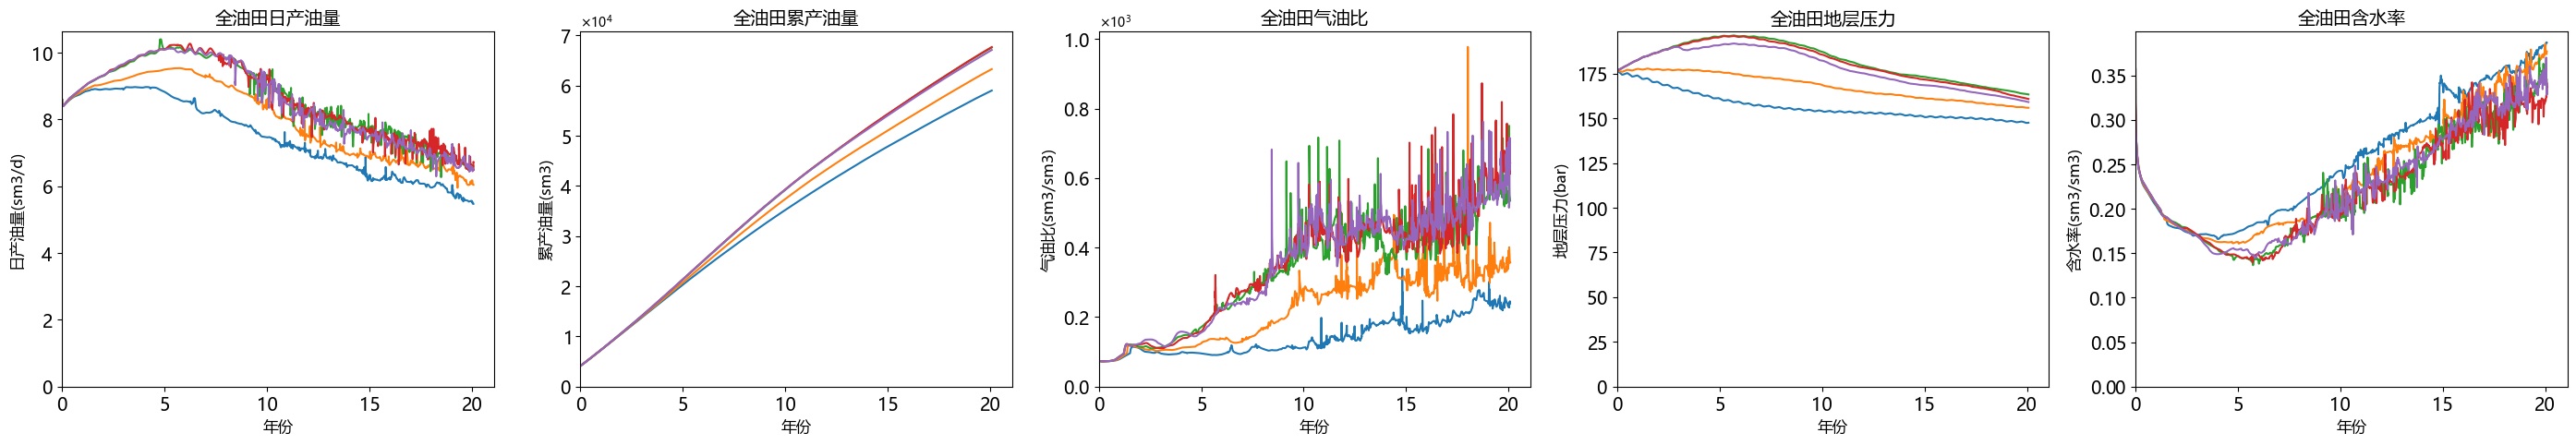

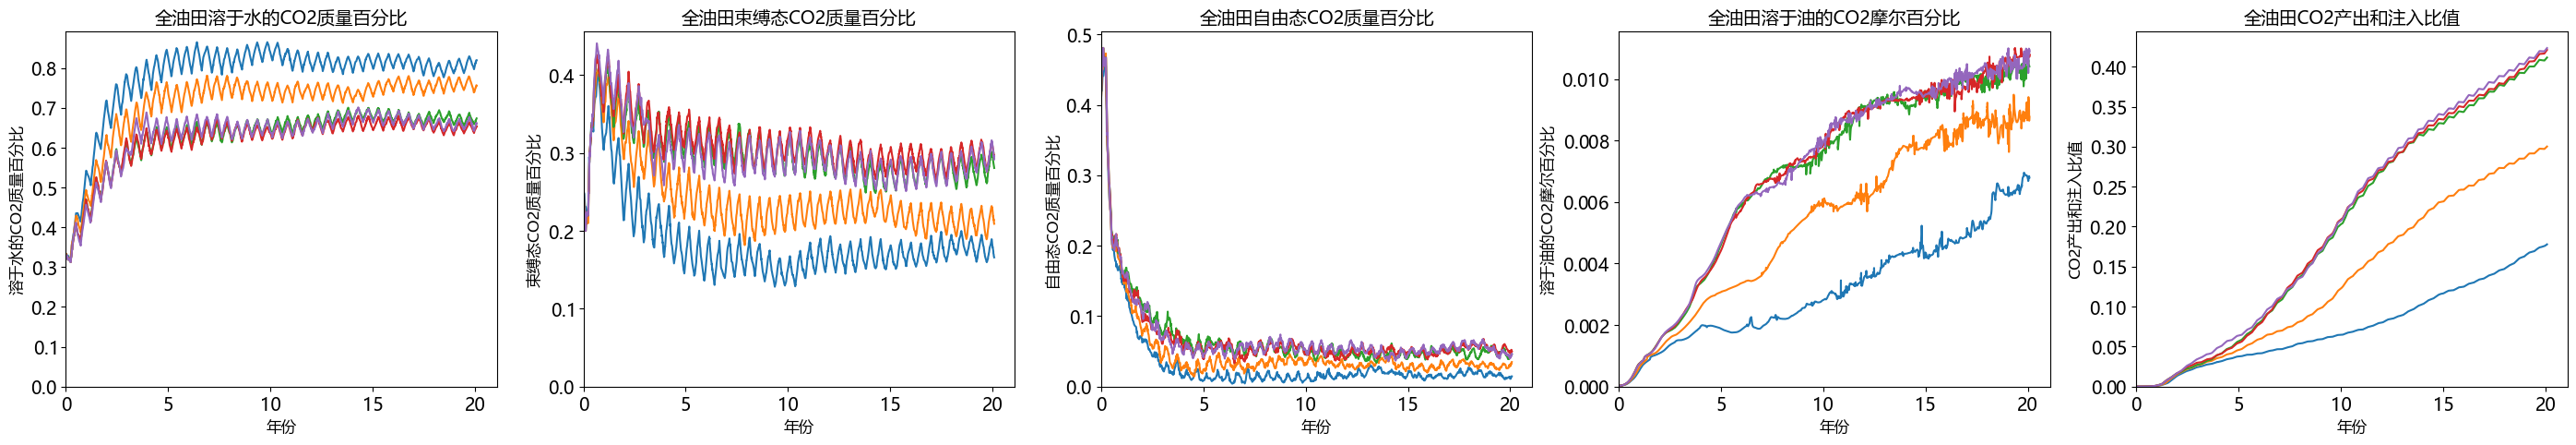

In [3]:
# 0509 剔除不存在数据的数据行
# V4 增加了百分比的设置 0114
# 从Petrel导出excel后批量绘图
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import re 
import warnings
import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = ['Microsoft YaHei']
# plt.rcParams['axes.unicode_minus'] = False
 
# 创建字典，存储英文到中文的对应关系
prop_dict = {
    "Aqueous component mass": "溶于水的CO2质量百分比",
    "Component mass production rate": "CO2产量(质量)",
    "Immobile vapor component mass": "束缚态CO2质量百分比",
    "Liquid component mole fraction": "溶于油的CO2摩尔百分比",
    "Mobile vapor component mass": "自由态CO2质量百分比",
    "Gas mass injection rate": "CO2注入量(质量)",
    "Oil production cumulative": "累产油量",
    "Pressure": "地层压力",
    "Water mass injection rate": "注水量(质量)",
    "Gas injection rate" : "CO2注入量",
    "Gas reservoir density": "CO2地下密度",
    "Oil production rate": "日产油量",
    "Oil recovery efficiency" : "采收率",
    "Reservoir volume injection rate" : "地下体积注入量",
    "Water cut": "含水率",
    "Gas-oil ratio": "气油比",
    "Tracer production rate": "CO2产量",
    "Tracer production cumulative": "CO2产出和注入比值"
}

identifier_dict = {
    "Field": "全油田"
}
yunlv = ['Pos', 'Neg', 'PosNeg', 'NegPos']
EOR = ["Oil production rate", "Oil production cumulative", "Gas-oil ratio", "Pressure", "Water cut"]
CCS = ["Aqueous component mass", "Immobile vapor component mass", "Mobile vapor component mass", "Liquid component mole fraction", "Tracer production rate"]
CCS2 = ["Aqueous component mass", "Immobile vapor component mass", "Mobile vapor component mass", "Liquid component mole fraction", "Tracer production cumulative"]

# 无示踪剂用这个
# CCS = ["Aqueous component mass", "Immobile vapor component mass", "Mobile vapor component mass", "Liquid component mole fraction", "Component mass production rate" ]

def extract_number(name):
    try:
        return int(name.split('_')[-1])
    except ValueError:
        try:
            return int(name.split('diff')[-1])
        except ValueError:
            for idx, value in enumerate(yunlv):
                if value in name.split('_'):
                    return idx
            return float('inf')  # 返回一个很大的值，使其在排序时保持原来的顺序

class CustomScalarFormatter(ticker.ScalarFormatter):
    def __init__(self, threshold=1000, *args, **kwargs):
        self.threshold = threshold
        super().__init__(*args, **kwargs)

    def set_locs(self, locs):
        super().set_locs(locs)
        self.set_scientific(False)
        if any(abs(l) >= self.threshold for l in locs):
            self.set_scientific(True)

def draw_plots(df_path, plot_combo = 'EOR', legend_show=1):

    # 读取Excel文件
    df = pd.read_excel(df_path, header=None)

    # 自定义图例
    legends = df.iloc[2, 1:].dropna().tolist()

    # 初始化变量
    attributes = []
    start_indices = []
    identifiers = []
    # 找出属性起始行和属性名称
    for i, row in df.iterrows():
        if not pd.isna(row[0]) and all(pd.isna(row[1:])):
            identifiers.append(row[0].split(',')[0].strip())
            attributes.append(row[0].split(',')[-1].strip())
            start_indices.append(i)

    # 计算每个属性的结束行
    end_indices = start_indices[1:] + [len(df)]

    # 设置子图的排版参数
    if plot_combo == 'EOR':
        rows = 1 # 设置子图的行数
        cols = 5  # 设置子图的列数
        plot_attrs = EOR
        fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), gridspec_kw={'hspace': 0.3})
    elif plot_combo == 'CCS':
        rows = 1  # 设置子图的行数
        cols = 5  # 设置子图的列数
        plot_attrs = CCS
        fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows),  gridspec_kw={'hspace': 0.3})
    elif plot_combo == 'CCS2':
        rows = 1  # 设置子图的行数
        cols = 5  # 设置子图的列数
        plot_attrs = CCS2
        fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows),  gridspec_kw={'hspace': 0.3})

    plot_order = 0
    # 计算 all_storage 和 tracer_inj_cum
    all_storage = None
    tracer_inj_cum = None

    # 遍历所有属性，预计算所需的总和
    for attr, start_idx, end_idx in zip(attributes, start_indices, end_indices):
        if attr in ["Aqueous component mass", "Immobile vapor component mass", "Mobile vapor component mass"]:
            data = df.iloc[start_idx+4:end_idx, :]
            data.columns = df.iloc[start_idx+1, :]
            data = data.drop(columns=['X']).apply(pd.to_numeric, errors='coerce')
            
            # 创建一个不含全NaN行的新数据框
            valid_data = data.dropna(how='all')
            data_array = valid_data.fillna(0).to_numpy()
            
            if all_storage is None:
                all_storage = data_array
            else:
                # 确保形状匹配，可能需要调整
                if all_storage.shape == data_array.shape:
                    all_storage += data_array
                else:
                    # 处理形状不匹配的情况
                    print(f"Warning: Shape mismatch for {attr}. Skipping addition.")
                    
        elif attr == "Tracer injection cumulative":
            data = df.iloc[start_idx+4:end_idx, :]
            data.columns = df.iloc[start_idx+1, :]
            data = data.drop(columns=['X']).apply(pd.to_numeric, errors='coerce')
            
            # 移除全是NaN的行
            valid_data = data.dropna(how='all')
            data_array = valid_data.fillna(0).to_numpy()
            tracer_inj_cum = data_array
    
    # 确保all_storage和tracer_inj_cum是DataFrame
    if all_storage is not None:
        all_storage = pd.DataFrame(all_storage)
    if tracer_inj_cum is not None:
        tracer_inj_cum = pd.DataFrame(tracer_inj_cum)

    # 遍历 plot_attrs 并绘图
    for prop in plot_attrs:
        for idx, (attr, start_idx, end_idx) in enumerate(zip(attributes, start_indices, end_indices)):
            if attr == prop:

                row = plot_order // cols
                col = plot_order % cols
                ax = axes[row, col] if rows > 1 and cols > 1 else axes[plot_order]

                match = re.search(r'\[(.*?)\]', df.iloc[start_idx+3, 1])  # type: ignore
                if match:
                    unit_ = '(' + match.group(1) + ')'
                    if unit_ == '(kg)':
                        unit_ = ''                    
                else:
                    unit_ = ''
                    
                data = df.iloc[start_idx+4:end_idx, :]
                data.columns = df.iloc[start_idx+1, :]
                
                # 处理时间列
                data['X'] = pd.to_datetime(data['X'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
                
                # 过滤掉X列无效的行
                data = data[data['X'].notna()]
                
                # 将其他列转换为数值类型
                data2 = data.drop(columns=['X']).apply(pd.to_numeric, errors='coerce')
                
                # 计算年份信息
                data['Year'] = data['X'].dt.year
                data['YearCount'] = data['X'].dt.year + (data['X'].dt.dayofyear - 1) / 365.25
                data['YearCount'] = data['YearCount'] - data['YearCount'].min()
                
                # 根据 prop 的类型处理数据
                if prop in ["Aqueous component mass", "Immobile vapor component mass", "Mobile vapor component mass"]:
                    if all_storage is not None:
                        # 对每一列分别处理，去除NaN值
                        for col_idx, legend in enumerate(legends):
                            if col_idx < data2.shape[1]:  # 确保列索引有效
                                # 创建仅包含当前列有效数据的mask
                                valid_mask = ~data2.iloc[:, col_idx].isna()
                                
                                # 修复：使用numpy数组索引而不是Series索引
                                valid_indices = np.where(valid_mask.values)[0]
                                
                                if all_storage.shape[0] > 0 and col_idx < all_storage.shape[1]:
                                    # 仅对有效行进行处理
                                    for i in valid_indices:
                                        if i < len(all_storage) and all_storage.iloc[i, col_idx] != 0:
                                            data2.iloc[i, col_idx] = data2.iloc[i, col_idx] / all_storage.iloc[i, col_idx]
                                        else:
                                            data2.iloc[i, col_idx] = 0
                
                elif prop == "Tracer production cumulative" and tracer_inj_cum is not None:
                    # 对每一列分别处理，去除NaN值
                    for col_idx, legend in enumerate(legends):
                        if col_idx < data2.shape[1]:  # 确保列索引有效
                            # 创建仅包含当前列有效数据的mask
                            valid_mask = ~data2.iloc[:, col_idx].isna()
                            
                            # 修复：使用numpy数组索引而不是Series索引
                            valid_indices = np.where(valid_mask.values)[0]
                            
                            if tracer_inj_cum.shape[0] > 0 and col_idx < tracer_inj_cum.shape[1]:
                                # 仅对有效行进行处理
                                for i in valid_indices:
                                    if i < len(tracer_inj_cum) and tracer_inj_cum.iloc[i, col_idx] != 0:
                                        data2.iloc[i, col_idx] = data2.iloc[i, col_idx] / tracer_inj_cum.iloc[i, col_idx]
                                    else:
                                        data2.iloc[i, col_idx] = 0

                # 获取列名和对应的索引
                sorted_legends = sorted(legends, key=extract_number)
                lines = []
                for legend in sorted_legends:
                    # 找到 legends 中对应的索引
                    index = legends.index(legend)
                    if index < data2.shape[1]:  # 确保索引有效
                        # 获取当前列的有效数据
                        current_col_data = data2.iloc[:, index]
                        valid_mask = ~current_col_data.isna()
                        
                        # 修复：使用numpy数组进行布尔索引
                        valid_mask_array = valid_mask.values
                        
                        if np.any(valid_mask_array):  # 确保有有效数据
                            # 只绘制有效数据点
                            valid_years = data['YearCount'].values[valid_mask_array]
                            valid_values = current_col_data.values[valid_mask_array]
                            
                            line, = ax.plot(valid_years, valid_values, label=legend)
                            lines.append(line)

                chinese_title = identifier_dict.get(identifiers[idx], identifiers[0]) + prop_dict.get(attr, attr)
                formatter = CustomScalarFormatter(threshold=1000, useMathText=True)
                formatter.set_scientific(True)
                formatter.set_powerlimits((-1, 1))  # 设置科学计数法的显示范围
                ax.yaxis.set_major_formatter(formatter)

                ax.set_title(chinese_title, fontsize=14)
                ax.set_xlabel('年份', fontsize=12)
                ax.set_ylabel(prop_dict.get(attr, attr) + f'{unit_}', fontsize=12)
                ax.tick_params(axis='x', labelsize=14)  # 设置X轴刻度标签字体大小为12
                ax.tick_params(axis='y', labelsize=14)  # 设置Y轴刻度标签字体大小为12
                # 设置X轴和Y轴的最小值为0
                ax.set_xlim(left=0)
                ax.set_ylim(bottom=0)
                if legend_show and lines:  # 确保有线条才显示图例
                    actual_legends = [line.get_label() for line in lines]
                    ax.legend(lines, actual_legends)
        plot_order += 1

    plt.tight_layout()
    plt.show()
# df_path = r'D:\NEW_DATA\Models\化子平\Plotting_0002_resampled.xlsx'
df_path = r'D:\NEW_DATA\Models\化子坪\WAG-注气速率.xlsx'

draw_plots(df_path, plot_combo='EOR', legend_show=0)
draw_plots(df_path, plot_combo='CCS2', legend_show=0)

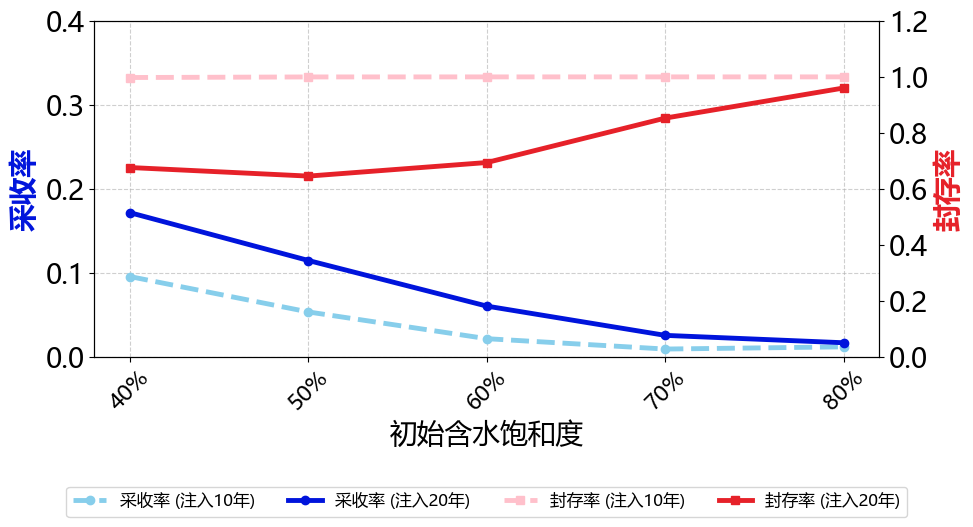

In [ ]:
# 0623 增加了图例输出控制
# 0618 机理模型图版，增加了ymin, ymax控制，颜色统一
# 0616 图版
# 单因素采收率和封存率模拟结果
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
test_df = pd.DataFrame()
def plot_dual_axis(df_path, legend_list=False, prop_name = False, y1_min=0, y1_max=0.08, y2_min=0.0, y2_max=1.0, show_legend=False):
    df = pd.read_excel(df_path, header=None)

    # 自定义图例
    legends = df.iloc[2, 1:].dropna().tolist()

    # 初始化变量
    attributes = []
    start_indices = []

    # 找出属性起始行和属性名称
    for i, row in df.iterrows():
        if not pd.isna(row[0]) and all(pd.isna(row[1:])):
            attributes.append(row[0].split(',')[1].strip())
            start_indices.append(i)

    # 计算每个属性的结束行
    end_indices = start_indices[1:] + [len(df)]

    Component_df = pd.DataFrame()
    injection_df = pd.DataFrame()
    OPC_df = pd.DataFrame()

    for idx, (attr, start_idx, end_idx) in enumerate(zip(attributes, start_indices, end_indices)):
        data = df.iloc[start_idx + 4:end_idx, :]
        data.columns = df.iloc[start_idx + 1, :]
        data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], format='%m/%d/%Y')
        # data2 = data.drop(columns=[data.columns[0]]).apply(pd.to_numeric, errors='coerce')
        data2 = data.copy()  # 创建副本以保留原始数据
        data2.iloc[:, 1:] = data2.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
        if attr == 'Tracer production cumulative':
            Component_df = data2
        if attr == 'Tracer injection cumulative':
            injection_df = data2
        if attr == 'Oil recovery efficiency':
            OPC_df = data2

    Component_df = Component_df.reset_index(drop=True)
    Component_df.iloc[:, 1:] = Component_df.iloc[:, 1:].fillna(method='ffill')

    injection_df = injection_df.reset_index(drop=True)
    injection_df.iloc[:, 1:] = injection_df.iloc[:, 1:].fillna(method='ffill')
    # 计算封存率
    # 创建 storage_rate_df 的副本以保留原始数据
    storage_rate_df = Component_df.copy()

    # 替换 injection_df 中的 0 为一个非常小的值（避免除以 0 的错误）
    safe_injection_df = injection_df.iloc[:, 1:].replace(0, 1e-10)

    # 仅对第二列及其之后的列进行计算
    storage_rate_df.iloc[:, 1:] = (1 - Component_df.iloc[:, 1:] / safe_injection_df)

    # 将第二列及其之后的列强制转换为数值类型（避免 dtype 问题）
    storage_rate_df.iloc[:, 1:] = storage_rate_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
    # 仅对第二列及其之后的列进行插值
    # storage_rate_df.iloc[:, 1:] = storage_rate_df.iloc[:, 1:].interpolate(method='linear')

    # 第一列（日期列）保持不变
    storage_rate_df.iloc[:, 0] = Component_df.iloc[:, 0]

    # 仅对第二列及其之后的列进行插值
    # OPC_df.iloc[:, 1:] = OPC_df.iloc[:, 1:].interpolate(method='linear')
    # 第一列（日期列）保持不变
    OPC_df.iloc[:, 0] = OPC_df.iloc[:, 0]  # 这行实际上可省略，因为第一列没有被修改

    # 筛选第一列值为 '2014-01-01' 的行
    storage_rate_2014 = storage_rate_df[storage_rate_df.iloc[:, 0] == pd.Timestamp('2014-01-01 00:00:00')]
    storage_rate_2024 = storage_rate_df[storage_rate_df.iloc[:, 0] == pd.Timestamp('2024-01-01 00:00:00')]
    recovery_rate_2014 = OPC_df[OPC_df.iloc[:, 0] == pd.Timestamp('2014-01-01 00:00:00')]
    recovery_rate_2024 = OPC_df[OPC_df.iloc[:, 0] == pd.Timestamp('2024-01-01 00:00:00')]

    # 提取值作为 Y 轴数据
    storage_rate_2014 = storage_rate_2014.iloc[:, 1:].values.flatten()
    storage_rate_2024 = storage_rate_2024.iloc[:, 1:].values.flatten()
    recovery_rate_2014 = recovery_rate_2014.iloc[:, 1:].values.flatten()
    recovery_rate_2024 = recovery_rate_2024.iloc[:, 1:].values.flatten()

    # 创建图表
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()  # 创建次坐标轴

    x = range(len(legends))
    # 绘制数据并保存线条对象，使用同色系的浅色和深色
    line1 = ax1.plot(x, recovery_rate_2014, color='#87CEEB', label='采收率 (注入10年)', linestyle='--', marker='o', linewidth=3.5)  # 浅蓝色
    line2 = ax1.plot(x, recovery_rate_2024, color='#0014DC', label='采收率 (注入20年)', linestyle='-', marker='o', linewidth=3.5)    # 深蓝色
    line3 = ax2.plot(x, storage_rate_2014, color='#FFC0CB', label='封存率 (注入10年)', linestyle='--', marker='s', linewidth=3.5)  # 中等红色
    line4 = ax2.plot(x, storage_rate_2024, color='#e62129', label='封存率 (注入20年)', linestyle='-', marker='s', linewidth=3.5)    # 深红色

    # 设置 X 轴
    ax1.set_xticks(x)
    if legend_list:
        ax1.set_xticklabels(legend_list, rotation=45, fontsize=16)
    else:
        ax1.set_xticklabels(legends, rotation=45, fontsize=16)
    
    if prop_name:
        ax1.set_xlabel(prop_name, fontsize=20)
    else:
        ax1.set_xlabel('Cases', fontsize=20)

    # 设置 Y 轴
    ax1.set_ylabel('采收率', fontsize=20, color='#0014DC', weight=600)  # 使用深蓝色
    ax2.set_ylabel('封存率', fontsize=20, color='#e62129', weight=600)# 使用深红色
    ax1.set_ylim(y1_min, y1_max)
    ax2.set_ylim(y2_min, y2_max)
    # 设置Y轴刻度字体大小
    ax1.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)

    # 添加图例
    if show_legend:
        lines = line1 + line2 + line3 + line4
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='lower center', fontsize=12, ncol=len(lines), bbox_to_anchor=(0.5, -0.5))

    # 网格和标题
    ax1.grid(visible=True, linestyle='--', alpha=0.6)
    # plt.title('单因素采收率和封存率模拟结果', fontsize=18, pad=20)

    plt.tight_layout()
    plt.show()

#机理模型渗透率在下面
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\SWAT.xlsx', ['40%', '50%', '60%', '70%'], '初始含水饱和度', y1_min=0, y1_max=0.3, y2_min=0, y2_max=1.2, show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\注入速率.xlsx', ['5.6', '8.4', '11.2', '14.0', '16.8'], '注入速率（t/d）', y1_min=0.1, y1_max=0.4, y2_min=0, y2_max=1.2, show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\Plotting_0062.xlsx', [ 0.2, 0.3, 0.5, 1], '各向异性', y1_min=0, y1_max=0.3, y2_min=0, y2_max=1.2, show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\极差.xlsx', [1, 2, 5, 10], '极差', y1_min=0.1, y1_max=0.3, y2_min=0, y2_max=1.2, show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\渗透率韵律.xlsx', ['正韵律', '正反韵律', '反正韵律', '反韵律'], '渗透率韵律',  y1_min=0.1, y1_max=0.3, y2_min=0.5, y2_max=1.2,show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\WAG-注水周期.xlsx', ['2m', '3m', '4m', '6m', '12m'], '注水周期', y1_min=0.1, y1_max=0.3, y2_min=0, y2_max=1.2, show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\WAG-注气周期.xlsx', ['2m', '3m', '4m', '6m', '12m'], '注气周期', y1_min=0.1, y1_max=0.3, y2_min=0, y2_max=1.2, show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\WAG-气水比.xlsx', ['1:1', '2:1', '3:1', '4:1', '5:1'], '气水比', y1_min=0, y1_max=0.3, y2_min=0, y2_max=1.2, show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\Depth.xlsx', ['1000m', '2000m', '3000m', '4000m'], '深度', y1_min=0, y1_max=0.4, y2_min=0, y2_max=1.2, show_legend=False)
# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\Temp.xlsx', ['40°C', '50°C', '60°C', '70°C', '80°C'], '温度', y1_min=0, y1_max=0.4, y2_min=0, y2_max=1.2, show_legend=False)
plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\SWAT.xlsx', ['40%', '50%', '60%', '70%', '80%'], '初始含水饱和度', y1_min=0, y1_max=0.4, y2_min=0, y2_max=1.2, show_legend=True)


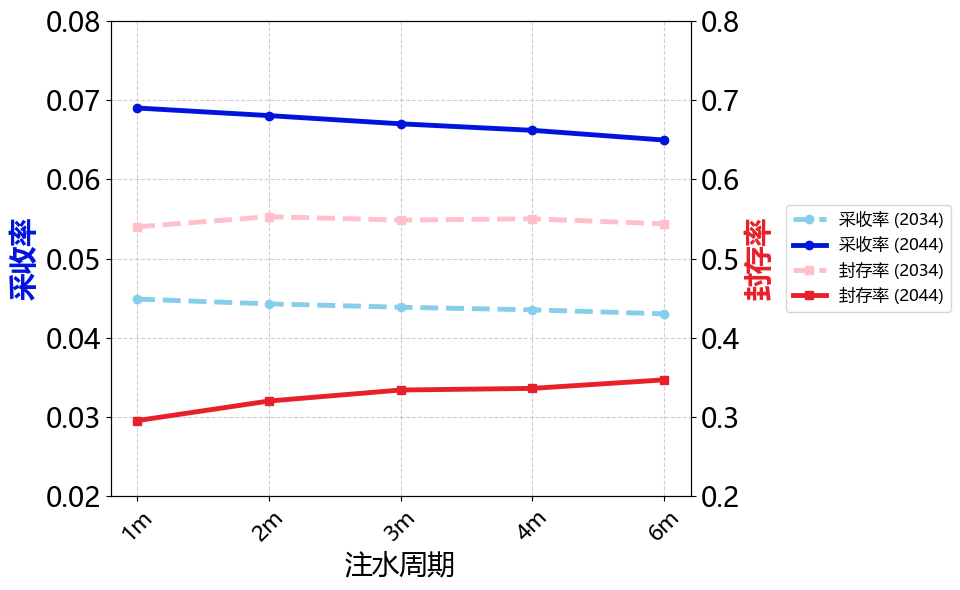

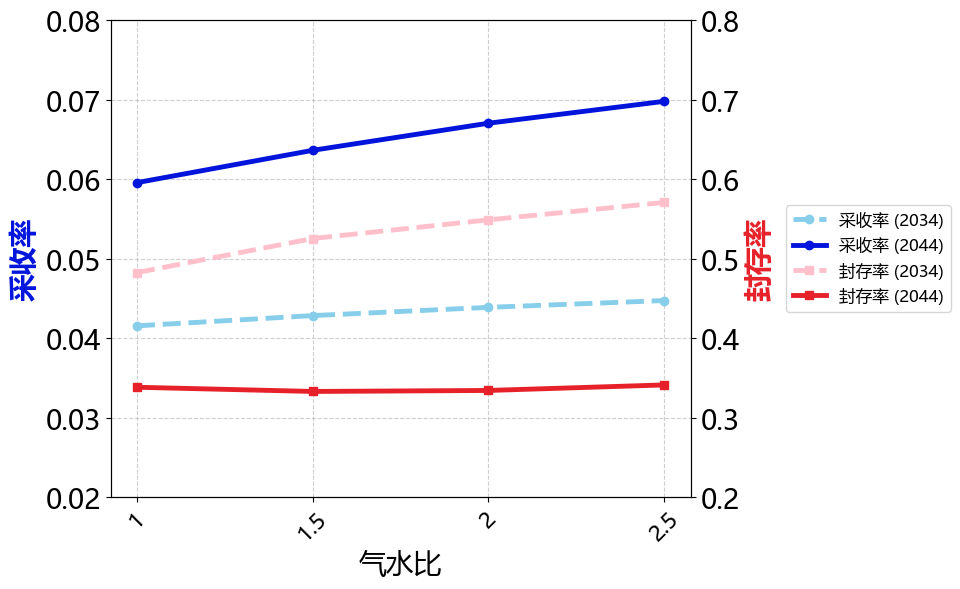

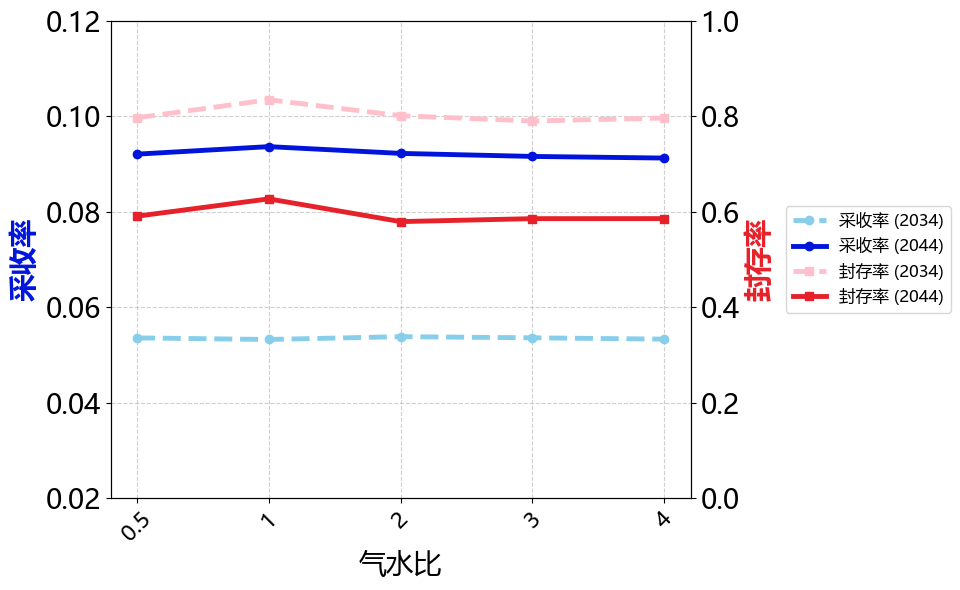

In [ ]:
# 0623 实际模型图版 增加了图例输出控制
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")

def plot_dual_axis(df_path, legend_list=False, prop_name=False, start_date='2024-7-4', end_date='2034-7-4', 
                  his_opc=0.0, OIP=1.0, y1_min=0.0, y1_max=0.4, y2_min=0.0, y2_max=1.0, show_legend=True):
    try:
        # 检查文件是否存在
        if not os.path.exists(df_path):
            raise FileNotFoundError(f"文件不存在: {df_path}")
            
        df = pd.read_excel(df_path, header=None)

        # 自定义图例
        legends = df.iloc[2, 1:].dropna().tolist()

        # 初始化变量
        attributes = []
        start_indices = []

        # 找出属性起始行和属性名称
        for i, row in df.iterrows():
            if not pd.isna(row[0]) and all(pd.isna(row[1:])):
                attributes.append(row[0].split(',')[1].strip())
                start_indices.append(i)

        # 计算每个属性的结束行
        end_indices = start_indices[1:] + [len(df)]

        Component_df = pd.DataFrame()
        injection_df = pd.DataFrame()
        OPC_df = pd.DataFrame()

        for idx, (attr, start_idx, end_idx) in enumerate(zip(attributes, start_indices, end_indices)):
            data = df.iloc[start_idx + 4:end_idx, :]
            data.columns = df.iloc[start_idx + 1, :]
            
            try:
                data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], format='%Y/%m/%d')
            except Exception as e:
                try:
                    data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0])
                except Exception as e2:
                    raise

            data2 = data.copy()
            try:
                data2.iloc[:, 1:] = data2.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
            except Exception as e:
                raise

            if attr == 'Tracer production cumulative':
                Component_df = data2
            if attr == 'Tracer injection cumulative':
                injection_df = data2
            if attr == 'Oil production cumulative':
                OPC_df = data2

        # 检查数据框是否为空
        if Component_df.empty or injection_df.empty or OPC_df.empty:
            raise ValueError("某些必要的数据框为空")

        # 数据处理
        Component_df = Component_df.reset_index(drop=True)
        Component_df.iloc[:, 1:] = Component_df.iloc[:, 1:].fillna(method='ffill')

        injection_df = injection_df.reset_index(drop=True)
        injection_df.iloc[:, 1:] = injection_df.iloc[:, 1:].fillna(method='ffill')

        # 计算采收率
        OPC_df = OPC_df.reset_index(drop=True)
        OPC_df.iloc[:, 1:] = (OPC_df.iloc[:, 1:] + his_opc) / OIP

        # 计算封存率
        storage_rate_df = Component_df.copy()
        safe_injection_df = injection_df.iloc[:, 1:].replace(0, 1e-10)
        storage_rate_df.iloc[:, 1:] = (1 - Component_df.iloc[:, 1:] / safe_injection_df)
        storage_rate_df.iloc[:, 1:] = storage_rate_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
        storage_rate_df.iloc[:, 0] = Component_df.iloc[:, 0]

        # 筛选特定日期的数据
        try:
            start_timestamp = pd.Timestamp(start_date)
            end_timestamp = pd.Timestamp(end_date)
            
            storage_rate_start = storage_rate_df[storage_rate_df.iloc[:, 0] == start_timestamp]
            storage_rate_end = storage_rate_df[storage_rate_df.iloc[:, 0] == end_timestamp]
            recovery_rate_start = OPC_df[OPC_df.iloc[:, 0] == start_timestamp]
            recovery_rate_end = OPC_df[OPC_df.iloc[:, 0] == end_timestamp]

            if storage_rate_start.empty or storage_rate_end.empty or recovery_rate_start.empty or recovery_rate_end.empty:
                raise ValueError(f"未找到指定日期的数据: {start_date} 或 {end_date}")
        except Exception as e:
            raise

        # 提取值作为 Y 轴数据
        storage_rate_start = storage_rate_start.iloc[:, 1:].values.flatten()
        storage_rate_end = storage_rate_end.iloc[:, 1:].values.flatten()
        recovery_rate_start = recovery_rate_start.iloc[:, 1:].values.flatten()
        recovery_rate_end = recovery_rate_end.iloc[:, 1:].values.flatten()

        # 创建图表
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax2 = ax1.twinx()

        x = range(len(legends))
        if legend_list:
            ax1.set_xticklabels(legend_list, rotation=45, fontsize=16)
        else:
            ax1.set_xticklabels(legends, rotation=45, fontsize=16)

        # 绘制数据并保存线条对象，使用同色系的浅色和深色
        line1 = ax1.plot(x, recovery_rate_start, color='#87CEEB', label=f'采收率 ({start_date.split("-")[0]})', linestyle='--', marker='o', linewidth=3.5)  # 浅蓝色
        line2 = ax1.plot(x, recovery_rate_end, color='#0014DC', label=f'采收率 ({end_date.split("-")[0]})', linestyle='-', marker='o', linewidth=3.5)    # 深蓝色
        line3 = ax2.plot(x, storage_rate_start, color='#FFC0CB', label=f'封存率 ({start_date.split("-")[0]})', linestyle='--', marker='s', linewidth=3.5)  # 中等红色
        line4 = ax2.plot(x, storage_rate_end, color='#e62129', label=f'封存率 ({end_date.split("-")[0]})', linestyle='-', marker='s', linewidth=3.5)    # 深红色
    
        ax1.set_xticks(x)
        if prop_name:
            ax1.set_xlabel(prop_name, fontsize=20)
        else:
            ax1.set_xlabel('Cases', fontsize=20)

        # 设置 Y 轴
        ax1.set_ylabel('采收率', fontsize=20, color='#0014DC', weight=600)  # 使用深蓝色
        ax2.set_ylabel('封存率', fontsize=20, color='#e62129', weight=600)# 使用深红色
        ax1.set_ylim(y1_min, y1_max)
        ax2.set_ylim(y2_min, y2_max)
        ax1.tick_params(axis='y', labelsize=20)
        ax2.tick_params(axis='y', labelsize=20)

        # 添加图例
        if show_legend:
            lines = line1 + line2 + line3 + line4
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.15, 0.5), fontsize=12)
            # ax1.legend(lines, labels, loc='lower center', fontsize=12, ncol=len(lines), bbox_to_anchor=(0.5, -0.5))

        ax1.grid(visible=True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"发生错误: {str(e)}")
        raise

# plot_dual_axis(r'D:\NEW_DATA\Models\1. 机理模型\渗透率.xlsx',
#  [0.2, 0.6, 2, 6, 20], '渗透率', his_opc=0.0, OIP=130714, 
#   start_date='2014-01-02', end_date='2024-01-02',
#   y1_min=0, y1_max=0.3, y2_min=0, y2_max=1.2, show_legend=False)


# plot_dual_axis(r'D:\NEW_DATA\data\HZP\HZP_连续注气_resample.xlsx', 
#                 ['2/d','3/d','5/d','10t/d', '15t/d', '20t/d'], '注气速率',
#                 start_date='2034-7-4', end_date='2044-7-4',
#                 his_opc=0.0, OIP=731954, y1_min=0.02, y1_max=0.12, y2_min=0.0, y2_max=1.0)

# plot_dual_axis(r'D:\NEW_DATA\data\HZP\HZP_WAG_WINJ_PERIOD_resample.xlsx', 
#                 ['1m', '2m', '3m', '4m', '6m'], '注水周期',
#                 start_date='2034-7-4', end_date='2044-7-4',
#                 his_opc=0.0, OIP=731954, y1_min=0.02, y1_max=0.12, y2_min=0.0, y2_max=1.0)

# plot_dual_axis(r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_PERIOD_resample.xlsx', 
#                 ['1m', '2m', '3m', '4m', '6m'], '注气周期',
#                 start_date='2034-7-4', end_date='2044-7-4',
#                 his_opc=0.0, OIP=731954, y1_min=0.02, y1_max=0.12, y2_min=0.0, y2_max=1.0)

# plot_dual_axis(r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE_resample.xlsx', 
#                 ['3/d','5/d','10t/d', '15t/d', '20t/d'], '注气速率',
#                 start_date='2034-7-4', end_date='2044-7-4',
#                 his_opc=0.0, OIP=731954, y1_min=0.02, y1_max=0.12, y2_min=0.0, y2_max=1.0)

# plot_dual_axis(r'D:\NEW_DATA\data\BB\Plotting_CO2T_resample.xlsx', 
#                 ['10/d','15t/d', '20t/d', '25t/d'], '注气速率',
#                 start_date='2034-8-1', end_date='2044-8-1',
#                 his_opc=31290, OIP=1833150, y1_min=0.02, y1_max=0.08, y2_min=0.2, y2_max=0.8)

plot_dual_axis(r'D:\NEW_DATA\data\BB\Plotting_WAGW_resample.xlsx', 
                ['1m', '2m', '3m', '4m', '6m'], '注水周期',
                start_date='2034-8-1', end_date='2044-8-1',
                his_opc=31290, OIP=1833150, y1_min=0.02, y1_max=0.08, y2_min=0.2, y2_max=0.8)

# plot_dual_axis(r'D:\NEW_DATA\data\BB\Plotting_WAGG_resample.xlsx', 
#                 ['1m', '2m', '3m', '4m', '6m'], '注气周期',
#                 start_date='2034-8-1', end_date='2044-8-1',
#                 his_opc=31290, OIP=1833150, y1_min=0.02, y1_max=0.08, y2_min=0.2, y2_max=0.8)

# plot_dual_axis(r'D:\NEW_DATA\data\BB\Plotting_TWAG_resample.xlsx', 
#                 ['10/d','15t/d', '20t/d', '25t/d'], '注气速率',
#                 start_date='2034-8-1', end_date='2044-8-1',
#                 his_opc=31290, OIP=1833150, y1_min=0.02, y1_max=0.08, y2_min=0.2, y2_max=0.8)

# 0626 
plot_dual_axis(r'D:\NEW_DATA\data\BB\Plotting_TWAG_resample.xlsx', 
                ['1','1.5', '2', '2.5'], '气水比',
                start_date='2034-8-1', end_date='2044-8-1',
                his_opc=31290, OIP=1833150, y1_min=0.02, y1_max=0.08, y2_min=0.2, y2_max=0.8 )

plot_dual_axis(r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE_resample.xlsx', 
                ['0.5','1','2', '3', '4'], '气水比',
                start_date='2034-7-4', end_date='2044-7-4',
                his_opc=0.0, OIP=731954, y1_min=0.02, y1_max=0.12, y2_min=0.0, y2_max=1.0)

In [ ]:
# NPV v5 0618 legend放外面，增加了一组只变油价，碳税，碳价格=0
# 0616 分开协同指数
# 0616 分成四组，对应四个场景
# 0613 支持 TRADE_CO2， ro, TAX_CO2数组形式，移除了跃阶函数
# 0609 更新自定义标签
# 0523 修正了cash flow 应该为diff
# 0303, Region flow, 针对实际模型（无外溢考虑）
# NPV v4 极限情况，0227，考虑碳税是所有产的C02，不仅仅是示踪剂出的CO2
# NPV v3 考虑了碳税和ETS最小值，成本最低
# NPV v2 考虑了碳税、碳交易
# 每个时间步是3个月，一年有4个季度
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import re
import warnings
import math
import matplotlib.ticker as ticker
from typing import List, Union, Optional
warnings.filterwarnings("ignore")
yunlv = ['Pos', 'Neg', 'PosNeg', 'NegPos']
plt.rcParams['font.family'] = ['Microsoft YaHei']

# region
def extract_number(name):
    try:
        return int(name.split('_')[-1])
    except ValueError:
        try:
            return int(name.split('diff')[-1])
        except ValueError:
            for idx, value in enumerate(yunlv):
                if value in name.split('_'):
                    return idx
            return float('inf')  # 返回一个很大的值，使其在排序时保持原来的顺序

def get_attr(df_path, attr=None):
    df = pd.read_excel(df_path, header=None)

    # 初始化变量
    attributes = []
    start_indices = []

    # 找出属性起始行和属性名称
    for i, row in df.iterrows():
        if not pd.isna(row[0]) and all(pd.isna(row[1:])):
            attributes.append(row[0].split(',')[1].strip())
            start_indices.append(i)

    # 计算每个属性的结束行
    end_indices = start_indices[1:] + [len(df)]

    # 根据属性名称返回对应的DataFrame
    for idx, (attribute, start_idx, end_idx) in enumerate(zip(attributes, start_indices, end_indices)):
        if attribute == attr:
            data = df.iloc[start_idx+4:end_idx, :]
            data.columns = df.iloc[start_idx+1, :]
            # 保留'X'列，不要在apply之前删除
            try:
                data['X'] = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d %H:%M:%S')
            except:
                data['X'] = pd.to_datetime(data.iloc[:, 0], format='%Y/%m/%d')

            # 将除了'X'列以外的其他列转换为数值类型
            data_df = data.drop(columns=['X']).apply(pd.to_numeric, errors='coerce')
            # 按年整理，空值跳过
            yearly_data = pd.DataFrame()
            for year, group in data_df.groupby(data['X'].dt.year):  # 使用data中的'X'列进行分组
                group = group.dropna()  # 跳过空值
                yearly_data = pd.concat([yearly_data, group], ignore_index=True)
            return yearly_data
    return pd.DataFrame()

def get_case_names(df_path):
    df = pd.read_excel(df_path, header=None)
    return df.iloc[2, 1:].dropna().tolist()

def calculate_npv(cash_flows, discount_rate=0.1, periods_per_year=1):
    npv = 0
    for i, cash in enumerate(cash_flows):
        # 将时间步转换为年数
        time_in_years = i / periods_per_year
        npv += cash / ((1 + discount_rate) ** time_in_years)
    return npv

# 原油产量，CO2注入量，注水量，CO2产量， 产水量，CO2封存量
# qt_o, qt_CO2_i, qt_W_i, qt_CO2_p, qt_W_p, Vt_CCS

# 设置替换字典
replacement_dict = {
    "_PosNeg": "正反韵律",
    "_NegPos": "反正韵律",
    "_Pos": "正韵律",
    "_Neg": "反韵律",
    "RES_INJ_base": "",
    "_": ""
}

# Heaviside 步进函数（单位阶跃函数）
def heaviside(x):
    return np.where(x < 0, 0, 1)

def calculate_synergy_index(x1: float, x2: float) -> float:
    """
    计算协同指数
    x1: 原油采收率
    x2: 1 - CO2产出率
    """
    if x1 == 0:  # 防止除零错误
        return 0
    return 23.688640 * (x2/x1)**8.418189 + 0.305869

def cal_npv_from_excel(df_path: str, csv_name: str, fig_title: str, n_cols: int = 3, n_rows: int = 2, 
                      ro: Union[float, List[float]] = 3173, r_CO2_i: float = 1.2, r_W_i: float = 20.6, 
                      r_re_CO2: float = 0.15, r_CO2: float = 0.65, r_re_W: float = 1.5, 
                      TAX_CO2: Union[float, List[float]] = 0.114, SUB_CO2: float = 0.114, 
                      TRADE_CO2: Union[float, List[float]] = 0.182, Limit2: float = 900000, 
                      x_labels: Optional[List[str]] = None, x_axis_name: str = '方案编号',
                      OIP: float = 725595, figsize_X = 12, show_legend = False):
    """
    qt_o: 原油产量, m3
    qt_CO2_i: 生产时间内累计CO2注入量, m3
    qt_W_i: 注水量, m3
    qt_W_p: 产水量, m3
    qt_CO2_p: 从生产井中分离CO2的量, m3
    q_re_CO2: CO2 回收量, m3
    ro: 原油价格, 3800 元/m3 (支持数组)
    r_CO2_i: CO2注入总成本，1.2 元/m3
    r_W_i: 水注入总成本， 20.6 元/m3
    r_re_W, 生产井采出水处理成本 1.5 元/m3
    r_W_, 注水成本, 5.56 元/m3
    r_CO2, CO2的生产收益, 0.65 元/m3
    r_re_CO2, 产出气回收CO2成本，0.15 元/m3
    TAX_CO2, 超出排放额所缴纳的碳税（若有）,  0.14 元/m3 (支持数组)
    SUB_CO2, 政府相关部门对碳封存的补贴,  0.114 元/m3
    TRADE_CO2, 排放额余量在碳交易市场的碳价（若有),  0.182 元/m3 (支持数组)
    Limit1, 考虑碳税时企业碳排放额, 900000 m3
    Limit2, 考虑碳交易时企业碳排放额, 900000 m3
    Vt_CCS: CO2封存量, m3
    x_labels: 自定义X轴标签列表，如None则使用默认编号
    x_axis_name: X轴坐标名称，默认为'方案编号'
    OIP: 原始地质储量，默认725595 m3
    """
    # 获取所有数据
    opc = get_attr(df_path, 'Oil production cumulative')
    gic = get_attr(df_path, 'Gas injection cumulative')
    gpc = get_attr(df_path, 'Gas production cumulative')
    wic = get_attr(df_path, 'Water injection cumulative')
    wpc = get_attr(df_path, 'Water production cumulative')
    ore = get_attr(df_path, 'Oil recovery efficiency')  # 添加原油采收率数据
    tic = get_attr(df_path, 'Tracer injection cumulative')  # 添加示踪剂注入量数据
    co2_prod = get_attr(df_path, 'Tracer production cumulative')
    oil_dens = get_attr(df_path, 'Oil density')  # 添加原油密度数据
    gas_dens = get_attr(df_path, 'Gas density')  # 添加气体密度数据
    gas_mass_inj = get_attr(df_path, 'Gas mass injection cumulative')  # 添加气体质量注入量数据
    oil_mass_prod = get_attr(df_path, 'Oil mass production cumulative')  # 添加原油质量产量数据

    # 检查数据是否为空
    if opc.empty or gic.empty or gpc.empty or tic.empty or co2_prod.empty:
        raise ValueError("某些必要的数据为空，请检查Excel文件中的数据")

    # 如果没有采收率数据，则计算采收率
    if ore.empty:
        ore = opc / OIP

    # 检查数据列数是否一致
    data_shapes = {
        'opc': opc.shape[1],
        'gic': gic.shape[1],
        'gpc': gpc.shape[1],
        'ore': ore.shape[1],
        'tic': tic.shape[1],
        'co2_prod': co2_prod.shape[1]
    }
    
    if len(set(data_shapes.values())) > 1:
        print("警告：数据列数不一致：")
        for name, shape in data_shapes.items():
            print(f"{name}: {shape}列")
        raise ValueError("所有数据集的列数必须相同")

    # 没有注水/产水值
    if wic.empty:
        wic = opc * 0
    if wpc.empty:
        wpc = opc * 0
    
    df = pd.read_excel(df_path, header=None)
    legends = df.iloc[2, 1:].dropna().tolist()
    # 获取列名和对应的索引
    sorted_legends = sorted(legends, key=extract_number)

    # 获取排序后的索引
    sorted_indices = [legends.index(legend) for legend in sorted_legends]
    
    # 检查索引是否在范围内
    max_index = max(data_shapes.values()) - 1
    if any(idx > max_index for idx in sorted_indices):
        print(f"警告：索引超出范围。最大索引应为{max_index}，但存在更大的索引")
        print(f"当前索引：{sorted_indices}")
        raise ValueError("索引超出数据范围")

    # 对所有数据进行排序
    opc = opc.iloc[:, sorted_indices]
    gic = gic.iloc[:, sorted_indices]
    wic = wic.iloc[:, sorted_indices]
    wpc = wpc.iloc[:, sorted_indices]
    co2_prod = co2_prod.iloc[:, sorted_indices]
    ore = ore.iloc[:, sorted_indices]  # 排序原油采收率数据
    tic = tic.iloc[:, sorted_indices]  # 排序示踪剂注入量数据

    # 如果原油密度数据不存在，创建默认值（在数据排序后创建）
    if oil_dens.empty:
        oil_dens = pd.DataFrame(867, index=opc.index, columns=opc.columns)
        print("警告：未找到原油密度数据，使用默认值867 kg/m³")
    else:
        oil_dens = oil_dens.iloc[:, sorted_indices]

    # 如果气体密度数据不存在，创建默认值
    if gas_dens.empty:
        gas_dens = pd.DataFrame(1.98, index=opc.index, columns=opc.columns)
        print("警告：未找到气体密度数据，使用默认值1.98 kg/m³")
    else:
        gas_dens = gas_dens.iloc[:, sorted_indices]

    # 如果质量数据不存在，创建空DataFrame
    if gas_mass_inj.empty:
        gas_mass_inj = pd.DataFrame(0, index=opc.index, columns=opc.columns)
    else:
        gas_mass_inj = gas_mass_inj.iloc[:, sorted_indices]

    if oil_mass_prod.empty:
        oil_mass_prod = pd.DataFrame(0, index=opc.index, columns=opc.columns)
    else:
        oil_mass_prod = oil_mass_prod.iloc[:, sorted_indices]

    # 0522 减去第一个值，因为这些值是在之前的基础上累积的，所以要减去第一个值
    opc = opc - opc.iloc[0]
    gic = gic - gic.iloc[0]
    wic = wic - wic.iloc[0]
    wpc = wpc - wpc.iloc[0]
    co2_prod = co2_prod - co2_prod.iloc[0]

    co2_store = gic - co2_prod
    co2_store = co2_store.iloc[:, sorted_indices]

    case_names = get_case_names(df_path)
    replaced_case_names = []
    for name in case_names:
        replaced_name = name
        # 循环替换，直到没有更多的替换可以进行
        while any(part in replaced_name for part in replacement_dict):
            for part, new_part in replacement_dict.items():
                replaced_name = replaced_name.replace(part, new_part)
        replaced_case_names.append(replaced_name)
    
    # 如果没有提供自定义标签，使用默认的编号
    if x_labels is None:
        x_labels = list(range(1, len(case_names) + 1))
    
    # 确保x_labels长度与案例数匹配
    if len(x_labels) != len(case_names):
        print(f"警告：x_labels长度({len(x_labels)})与案例数量({len(case_names)})不匹配，将使用默认编号")
        x_labels = list(range(1, len(case_names) + 1))

    # 检查参数是否为数组
    if isinstance(ro, (list, np.ndarray)):
        ro_values = ro
    else:
        ro_values = [ro]
    
    if isinstance(TAX_CO2, (list, np.ndarray)):
        tax_values = TAX_CO2
    else:
        tax_values = [TAX_CO2] * len(ro_values)  # 如果是标量，复制为相同长度的数组
        
    if isinstance(TRADE_CO2, (list, np.ndarray)):
        trade_values = TRADE_CO2
    else:
        trade_values = [TRADE_CO2] * len(ro_values)  # 如果是标量，复制为相同长度的数组

    # 确保所有数组长度一致
    array_lengths = [len(ro_values), len(tax_values), len(trade_values)]
    if len(set(array_lengths)) > 1:
        raise ValueError(f"当多个参数为数组时，它们的长度必须相同。当前长度：ro={len(ro_values)}, TAX_CO2={len(tax_values)}, TRADE_CO2={len(trade_values)}")

    # 计算协同指数
    synergy_indices = []
    for col in range(len(sorted_indices)):
        try:
            # 计算换油率，使用最后一个非零值
            try:
                # 找到最后一个非零值的索引
                last_nonzero_oil = oil_mass_prod[oil_mass_prod.iloc[:, col] != 0].iloc[:, col].index[-1]
                last_nonzero_gas = gas_mass_inj[gas_mass_inj.iloc[:, col] != 0].iloc[:, col].index[-1]
                x1 = oil_mass_prod.iloc[last_nonzero_oil, col] / gas_mass_inj.iloc[last_nonzero_gas, col]
            except:
                # 如果质量数据不可用，使用体积和密度计算
                last_nonzero_oil = opc[opc.iloc[:, col] != 0].iloc[:, col].index[-1]
                last_nonzero_gas = gic[gic.iloc[:, col] != 0].iloc[:, col].index[-1]
                x1 = (opc.iloc[last_nonzero_oil, col] * oil_dens.iloc[last_nonzero_oil, col]) / (gic.iloc[last_nonzero_gas, col] * gas_dens.iloc[last_nonzero_gas, col])
            
            # 计算CO2封存率，使用最后一个非零值
            last_nonzero_co2 = co2_prod[co2_prod.iloc[:, col] != 0].iloc[:, col].index[-1]
            last_nonzero_tic = tic[tic.iloc[:, col] != 0].iloc[:, col].index[-1]
            x2 = 1 - co2_prod.iloc[last_nonzero_co2, col] / tic.iloc[last_nonzero_tic, col] if tic.iloc[last_nonzero_tic, col] != 0 else 0
            
            # print(f"方案 {col+1} 的协同指数计算:")
            # print(f"x1 (换油率): {x1}")
            # print(f"x2 (CO2封存率): {x2}")
            synergy_index = calculate_synergy_index(x1, x2)
            synergy_indices.append(synergy_index)
        except Exception as e:
            print(f"计算协同指数时出错 (列 {col}): {str(e)}")
            synergy_indices.append(0)

    # 创建一个图形和轴对象，使用2x1的子图布局
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figsize_X, 12), dpi=100, gridspec_kw={'height_ratios': [3, 1]})   
    
    # 定义颜色列表
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k', 'orange', 'purple', 'brown']
    
    # 存储所有NPV值用于保存CSV
    all_npv_data = {}
    
    # 为每个参数组合计算NPV并绘制
    color_idx = 0
    for i in range(len(ro_values)):
        ro_val = ro_values[i]
        tax_val = tax_values[i]
        trade_val = trade_values[i]
        
        npv_values = []
        
        for column in opc.columns:
            qt_o_delta = opc[column].diff().fillna(opc[column].iloc[0])
            qt_CO2_i_delta = gic[column].diff().fillna(gic[column].iloc[0])
            qt_W_i_delta = wic[column].diff().fillna(wic[column].iloc[0])
            qt_CO2_p_delta = co2_prod[column].diff().fillna(co2_prod[column].iloc[0])
            qt_W_p_delta = wpc[column].diff().fillna(wpc[column].iloc[0])
            Vt_CCS_delta = co2_store[column].diff().fillna(co2_store[column].iloc[0])
            GPC_delta = gpc[column].diff().fillna(gpc[column].iloc[0])

            cash_flows = (qt_o_delta * ro_val - 
                         qt_CO2_i_delta * r_CO2_i - 
                         qt_W_i_delta * r_W_i - 
                         qt_CO2_p_delta * r_re_CO2 + 
                         qt_CO2_p_delta * r_CO2 - 
                         qt_W_p_delta * r_re_W + 
                         Vt_CCS_delta * SUB_CO2 - 
                         GPC_delta * tax_val + 
                         (qt_CO2_p_delta - Limit2) * trade_val) / 10000000
            
            npv_values.append(calculate_npv(cash_flows))
        
        # 绘制当前参数组合的线
        color = colors[color_idx % len(colors)]
        label = f'油价={ro_val}元/m³, 碳税={tax_val}元/m³, 碳价={trade_val}元/m³'
        ax1.plot(range(len(case_names)), npv_values, marker='o', linestyle='-', 
                color=color, label=label, linewidth=2, markersize=6)
        
        # 存储NPV数据
        all_npv_data[f'NPV_ro_{ro_val}_tax_{tax_val}_trade_{trade_val}'] = npv_values
        color_idx += 1



    # 设置NPV图的属性
    ax1.set_xticks(range(len(case_names)))
    ax1.set_xticklabels(x_labels, ha='center')
    ax1.set_xlabel(x_axis_name, fontsize=18)
    ax1.set_ylabel('NPV / 千万元', fontsize=18)
    ax1.set_title('NPV对比', fontsize=18)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    # 将图例放在右侧空白处居中
    if show_legend:
        ax1.legend(fontsize=12, loc='center left', bbox_to_anchor=(1.05, 0.5))
        ax1.legend(fontsize=12, loc='lower left')

    # 绘制协同指数曲线
    ax2.plot(range(len(case_names)), synergy_indices, 'k-o', label='协同指数', linewidth=2, markersize=6)
    ax2.set_xticks(range(len(case_names)))
    ax2.set_xticklabels(x_labels, ha='center')
    ax2.set_xlabel(x_axis_name, fontsize=18)
    ax2.set_ylabel('协同指数', fontsize=18)
    ax2.set_title('协同指数对比', fontsize=18)
    ax2.tick_params(axis='x', labelsize=18)
    ax2.tick_params(axis='y', labelsize=18)
    ax2.grid(True, alpha=0.3)
    if show_legend:
        ax2.legend(fontsize=12, loc='center left', bbox_to_anchor=(1.05, 0.5))
        ax2.legend(fontsize=12, loc='best')
        
    plt.tight_layout()
    plt.show()

    # 为每个参数组合生成饼图
    for i in range(len(ro_values)):
        ro_val = ro_values[i]
        tax_val = tax_values[i]
        trade_val = trade_values[i]
        
        # 使用3x2布局
        n_cases = len(opc.columns)
        cases_per_page = n_cols * n_rows
        n_pages = math.ceil(n_cases / cases_per_page)
        
        # 定义现代扁平配色方案
        color_map = {
            '原油收入': '#2ECC71',      # 翡翠绿
            'CO2注入成本': '#E74C3C',   # 石榴红
            '注水成本': "#55B5F5",      # 彼得河蓝
            'CO2回收成本': '#F39C12',   # 橙色
            'CO2生产收入': "#434E48",   # 海绿宝石
            '产水处理成本': "#F7D9BF",  # 胡萝卜橙
            'CCS补贴': '#9B59B6',       # 紫水晶
            '碳税': "#530C04",          # 石榴红（深）
            '碳交易': "#0647C0"         # 绿松石
        }
        
        # 分页显示饼图
        for page in range(n_pages):
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
            fig.suptitle(f'各方案现金流组成分析\n原油价格: {ro_val}元/m³, 碳税: {tax_val}元/m³, 碳交易: {trade_val}元/m³', 
                        fontsize=16, y=0.95)
            
            # 收集所有标签用于统一图例
            all_labels = set()
            
            start_idx = page * cases_per_page
            end_idx = min(start_idx + cases_per_page, n_cases)
            
            for plot_idx, case_idx in enumerate(range(start_idx, end_idx)):
                row = plot_idx // n_cols
                col = plot_idx % n_cols
                ax = axes[row, col]
                
                column = opc.columns[case_idx]
                
                # 重新计算各项增量
                qt_o_delta = opc[column].diff().fillna(opc[column].iloc[0])
                qt_CO2_i_delta = gic[column].diff().fillna(gic[column].iloc[0])
                qt_W_i_delta = wic[column].diff().fillna(wic[column].iloc[0])
                qt_CO2_p_delta = co2_prod[column].diff().fillna(co2_prod[column].iloc[0])
                qt_W_p_delta = wpc[column].diff().fillna(wpc[column].iloc[0])
                Vt_CCS_delta = co2_store[column].diff().fillna(co2_store[column].iloc[0])
                GPC_delta = gpc[column].diff().fillna(gpc[column].iloc[0])
                
                # 计算各项总金额（取绝对值）
                oil_revenue = abs((qt_o_delta * ro_val).sum())
                co2_injection_cost = abs((qt_CO2_i_delta * r_CO2_i).sum())
                water_injection_cost = abs((qt_W_i_delta * r_W_i).sum())
                co2_recovery_cost = abs((qt_CO2_p_delta * r_re_CO2).sum())
                co2_production_revenue = abs((qt_CO2_p_delta * r_CO2).sum())
                water_treatment_cost = abs((qt_W_p_delta * r_re_W).sum())
                ccs_subsidy = abs((Vt_CCS_delta * SUB_CO2).sum())
                carbon_tax = abs((GPC_delta * tax_val).sum())
                carbon_trading = abs(((qt_CO2_p_delta - Limit2) * heaviside(Limit2 - qt_CO2_p_delta) * trade_val).sum())
                
                # 准备饼图数据（只包含非零项）
                labels = []
                sizes = []
                colors = []
                
                # 添加非零项
                items = [
                    ('原油收入', oil_revenue),
                    ('CO2注入成本', co2_injection_cost),
                    ('注水成本', water_injection_cost),
                    ('CO2回收成本', co2_recovery_cost),
                    ('CO2生产收入', co2_production_revenue),
                    ('产水处理成本', water_treatment_cost),
                    ('CCS补贴', ccs_subsidy),
                    ('碳税', carbon_tax),
                    ('碳交易', carbon_trading)
                ]
                
                for label, value in items:
                    if value > 1e-6:  # 只包含有意义的非零值
                        labels.append(label)
                        sizes.append(value)
                        colors.append(color_map[label])
                        all_labels.add(label)

                def autopct_format(pct):
                    return f'{pct:.1f}%' if pct >= 10 else ''     
                    
                # 绘制饼图（不显示标签）
                if sizes:  # 确保有数据可绘制
                    wedges, texts, autotexts = ax.pie(sizes, colors=colors, 
                                                    autopct=autopct_format, startangle=90,
                                                    textprops={'fontsize': 10, 'weight': 'bold'},
                                                    pctdistance=0.85)
                    
                    # 设置百分比文字颜色
                    for autotext in autotexts:
                        autotext.set_color('white')
                        autotext.set_weight('bold')
                
                ax.set_title(f'\n方案' + f'{case_idx+1}' + f'\n{x_axis_name}: ' + f'{x_labels[case_idx]}', fontsize=14, pad=0, weight='bold')
            
            # 隐藏多余的子图
            for plot_idx in range(end_idx - start_idx, cases_per_page):
                row = plot_idx // n_cols
                col = plot_idx % n_cols
                axes[row, col].axis('off')
            
            # 创建统一的图例
            legend_elements = []
            for label in sorted(all_labels):  # 按字母顺序排序
                legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color_map[label], 
                                                edgecolor='white', linewidth=0.5))
            
            # 在图的底部添加图例
            fig.legend(legend_elements, sorted(all_labels), 
                    loc='lower center', ncol=len(all_labels),  # 改为显示所有标签在一行
                    bbox_to_anchor=(0.5, 0.02), fontsize=12,
                    frameon=True, fancybox=False, shadow=False)  # 移除阴影和圆角

            
            plt.tight_layout()
            plt.subplots_adjust(top=0.85, bottom=0.1)
            plt.show()

    # 保存所有NPV数据到CSV
    if all_npv_data:
        df_npv = pd.DataFrame(all_npv_data)
        df_npv.index = x_labels
        df_npv.to_csv(csv_name)
        print(f"NPV数据已保存到: {csv_name}")
    else:
        # 如果只有一个ro值，保持原有的保存方式
        npv_values = []
        for column in opc.columns:
            qt_o_delta = opc[column].diff().fillna(opc[column].iloc[0])
            qt_CO2_i_delta = gic[column].diff().fillna(gic[column].iloc[0])
            qt_W_i_delta = wic[column].diff().fillna(wic[column].iloc[0])
            qt_CO2_p_delta = co2_prod[column].diff().fillna(co2_prod[column].iloc[0])
            qt_W_p_delta = wpc[column].diff().fillna(wpc[column].iloc[0])
            Vt_CCS_delta = co2_store[column].diff().fillna(co2_store[column].iloc[0])
            GPC_delta = gpc[column].diff().fillna(gpc[column].iloc[0])

            cash_flows = (qt_o_delta * ro_values[0] - 
                         qt_CO2_i_delta * r_CO2_i - 
                         qt_W_i_delta * r_W_i - 
                         qt_CO2_p_delta * r_re_CO2 + 
                         qt_CO2_p_delta * r_CO2 - 
                         qt_W_p_delta * r_re_W + 
                         Vt_CCS_delta * SUB_CO2 - 
                         GPC_delta * tax_values[0] + 
                         (Limit2 - qt_CO2_p_delta) * trade_values[0]) / 10000000
            
            npv_values.append(calculate_npv(cash_flows))
        
        df_npv = pd.DataFrame(npv_values, columns=["NPV"])
        df_npv.to_csv(csv_name, index=False)

    return

# endregion

# HZP
# cal_npv_from_excel(
#     r'D:\NEW_DATA\data\HZP\HZP_连续注气_resample.xlsx', 
#     r'D:\NEW_DATA\data\HZP\HZP_连续注气_resample_NPV.csv',
#     fig_title = '1各方案下协同指数和NPV对比',
#     n_cols = 3, 
#     n_rows = 2,
#     r_CO2 = 0.65, 
#     Limit2 = 10000000, 
#     ro = [3144, 5389, 3144, 3144,5389], 
#     TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
#     TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
#     r_CO2_i = 1.2, 
#     SUB_CO2 = 0,
#     x_labels = ['2t/d', '3/d','5/d','10t/d', '15t/d', '20t/d'], 
#     x_axis_name = '注气速率',

# )  

# cal_npv_from_excel(
#     r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE_resample.xlsx', 
#     r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE_resample_NPV.csv',
#     fig_title = '1各方案下协同指数和NPV对比',
#     n_cols = 3, 
#     n_rows = 2,
#     r_CO2 = 0.65, 
#     Limit2 = 10000000, 
#     ro = [3144, 5389, 3144, 3144,5389], 
#     TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
#     TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
#     r_CO2_i = 1.2, 
#     SUB_CO2 = 0,
#     x_labels = ['3/d','5/d','10t/d', '15t/d', '20t/d'], 
#     x_axis_name = '注气速率',
# )  

# cal_npv_from_excel(
#     r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_PERIOD_resample.xlsx', 
#     r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_PERIOD_resample_NPV.csv',
#     fig_title = '1各方案下协同指数和NPV对比',
#     n_cols = 3, 
#     n_rows = 2,
#     r_CO2 = 0.65, 
#     Limit2 = 10000000, 
#     ro = [3144, 5389, 3144, 3144,5389], 
#     TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
#     TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
#     r_CO2_i = 1.2, 
#     SUB_CO2 = 0,
#     x_labels = ['1m', '2m', '3m', '4m', '6m'], 
#     x_axis_name = '注气周期' ,
# )  
# cal_npv_from_excel(
#     r'D:\NEW_DATA\data\HZP\HZP_WAG_WINJ_PERIOD_resample.xlsx', 
#     r'D:\NEW_DATA\data\HZP\HZP_WAG_WINJ_PERIOD_resample_NPV.csv',
#     fig_title = '1各方案下协同指数和NPV对比',
#     n_cols = 3, 
#     n_rows = 2,
#     r_CO2 = 0.65, 
#     Limit2 = 10000000, 
#     ro = [3144, 5389, 3144, 3144,5389], 
#     TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
#     TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
#     r_CO2_i = 1.2, 
#     SUB_CO2 = 0,
#     x_labels = ['1m', '2m', '3m', '4m', '6m'], 
#     x_axis_name = '注水周期' ,
# )  

In [ ]:
# 0626 改为气水比
cal_npv_from_excel(
    r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE_resample.xlsx', 
    r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE_resample_NPV.csv',
    fig_title = '1各方案下协同指数和NPV对比',
    n_cols = 3, 
    n_rows = 2,
    r_CO2 = 0.65, 
    Limit2 = 10000000, 
    ro = [3144, 5389, 3144, 3144,5389], 
    TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
    TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
    r_CO2_i = 1.2, 
    SUB_CO2 = 0,
    x_labels = ['0.5','1','2', '3', '4'], 
    x_axis_name = '气水比',
    figsize_X = 10,
    show_legend = True
)  
cal_npv_from_excel(
    r'D:\NEW_DATA\data\BB\Plotting_TWAG_resample.xlsx', 
    r'D:\NEW_DATA\data\BB\Plotting_TWAG_resample_NPV.csv',
    fig_title = '1各方案下协同指数和NPV对比',
    n_cols = 2, 
    n_rows = 2,
    r_CO2 = 0.65, 
    Limit2 = 10000000, 
    ro = [3144, 5389, 3144, 3144,5389], 
    TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
    TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
    r_CO2_i = 1.2, 
    SUB_CO2 = 0,
    x_labels = ['1','1.5', '2', '2.5'], 
    x_axis_name = '气水比',
    figsize_X = 10,
    show_legend = True
)  

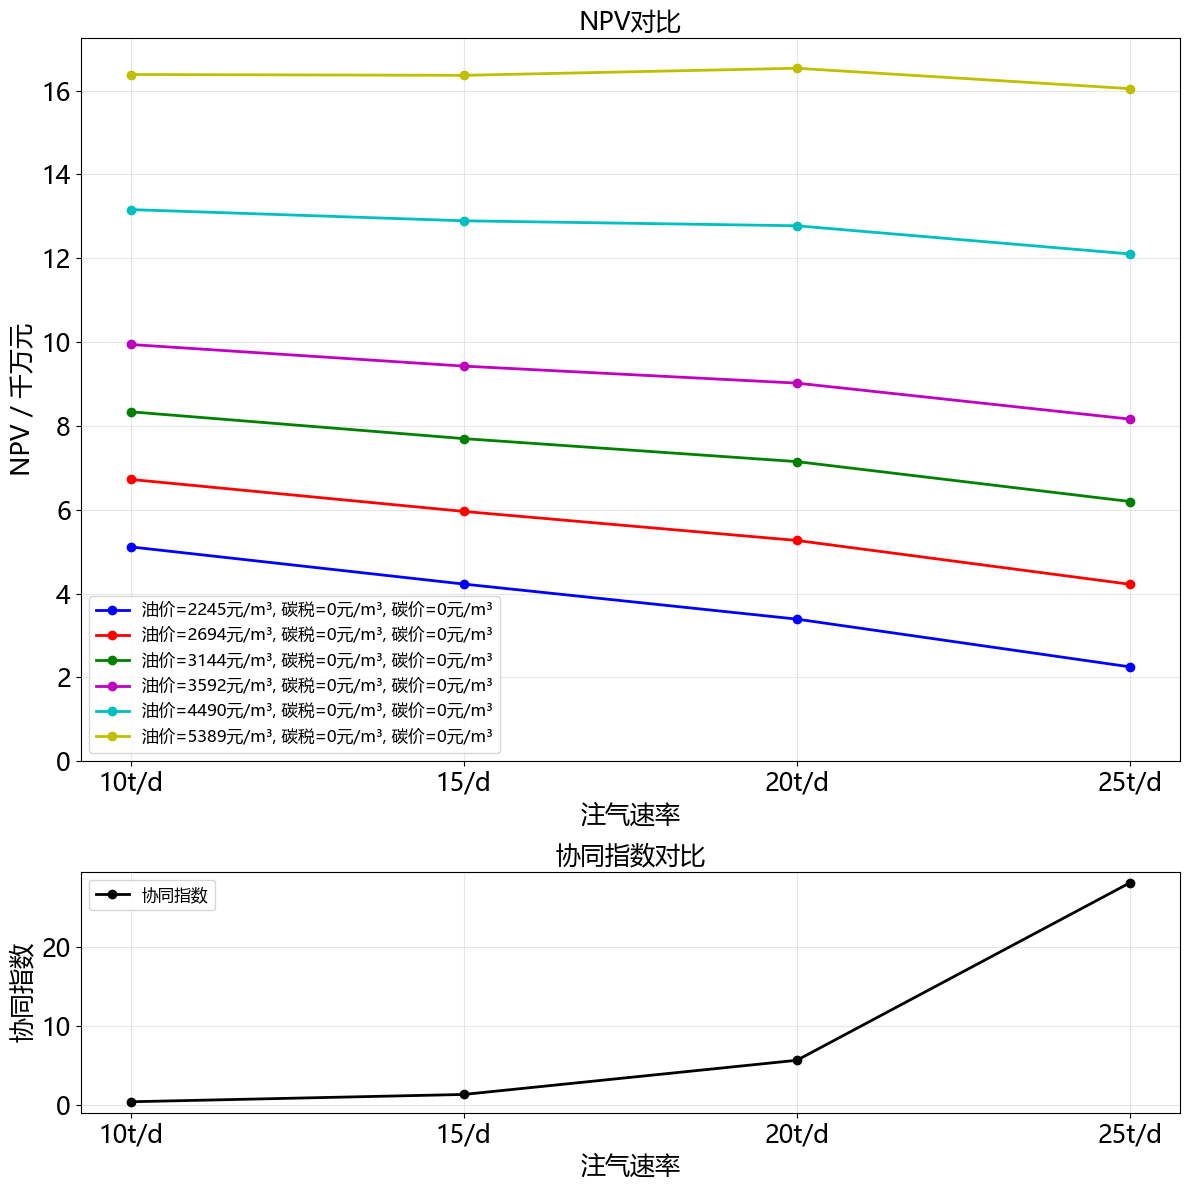

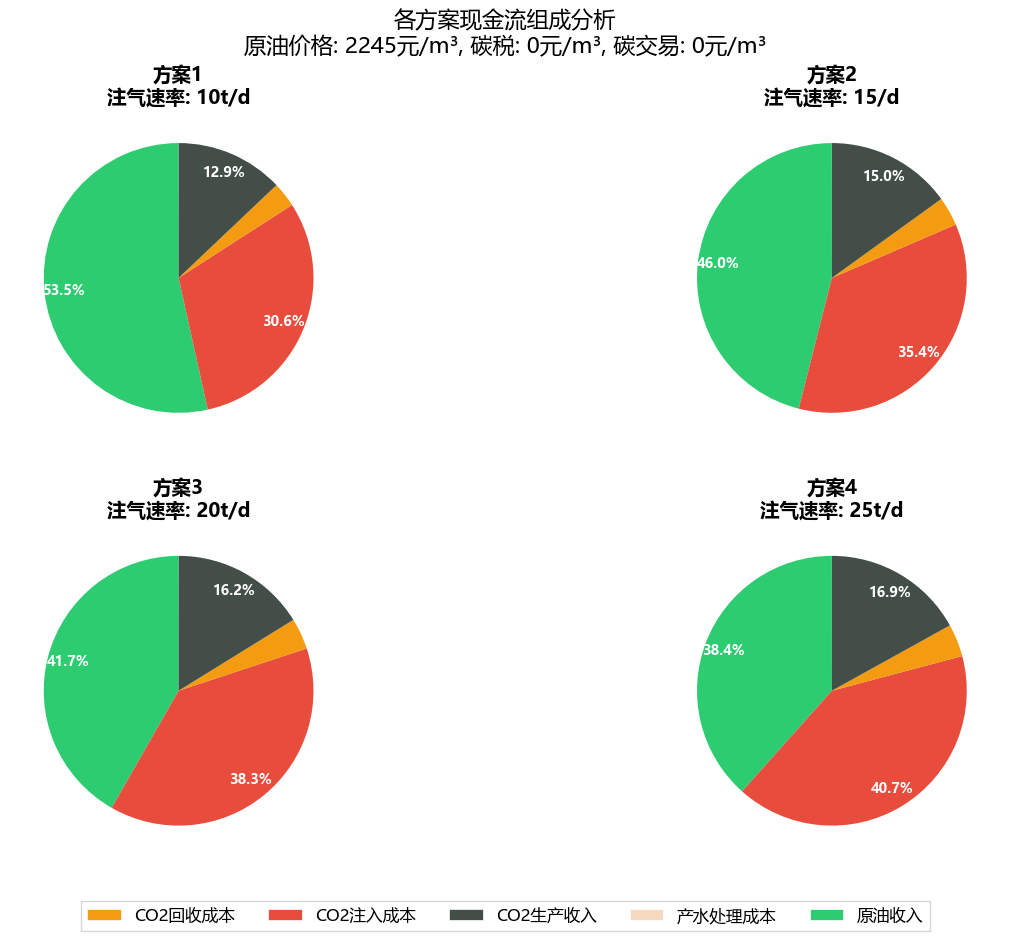

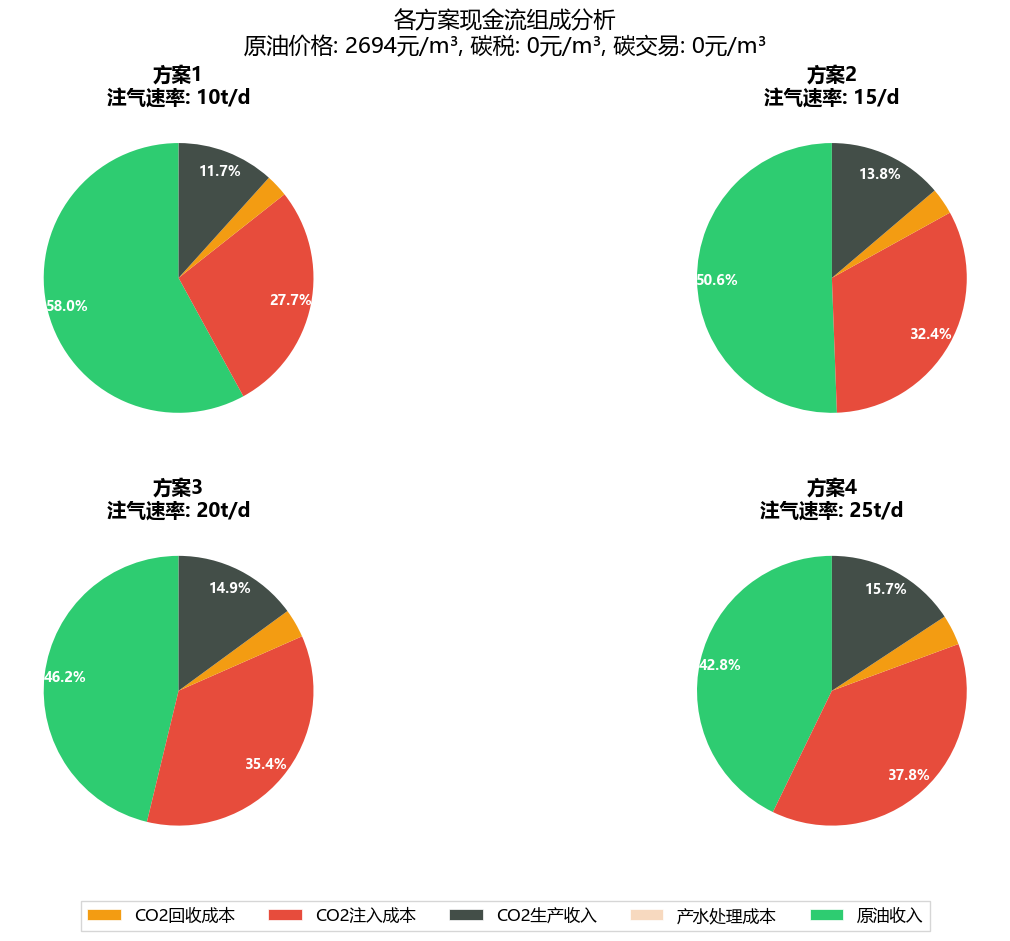

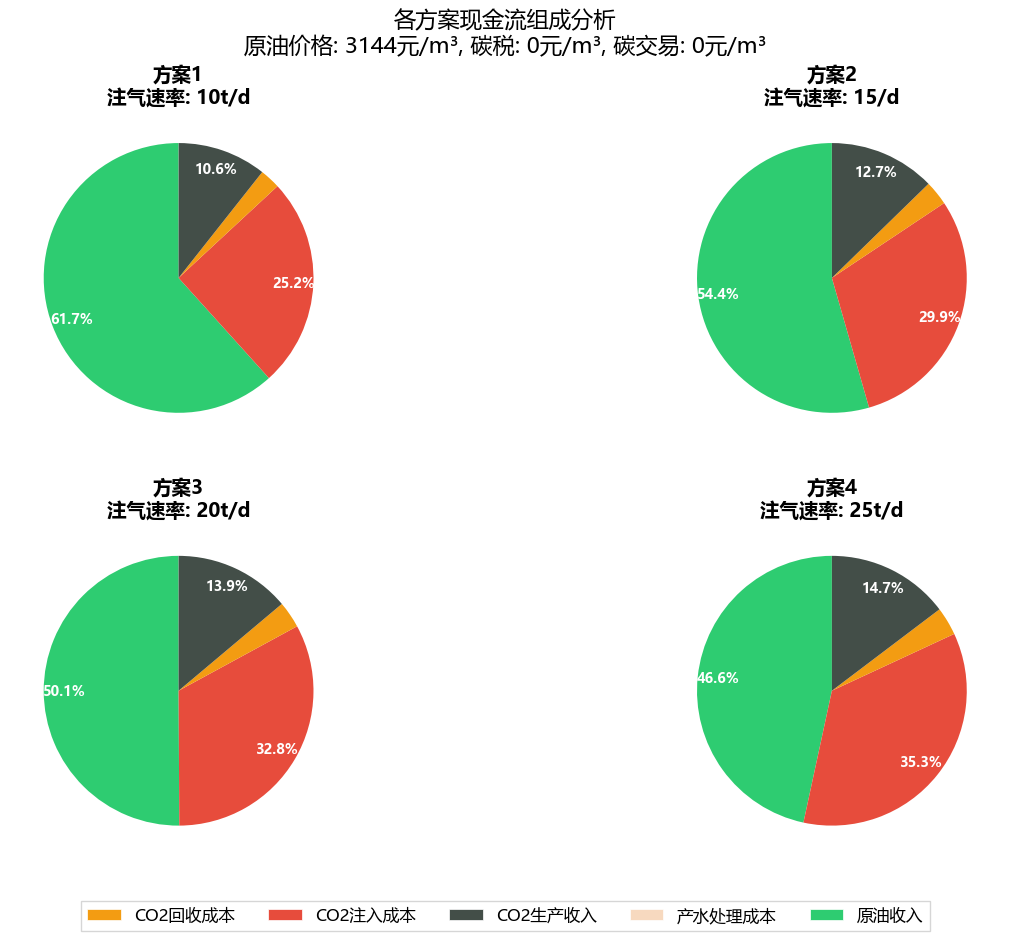

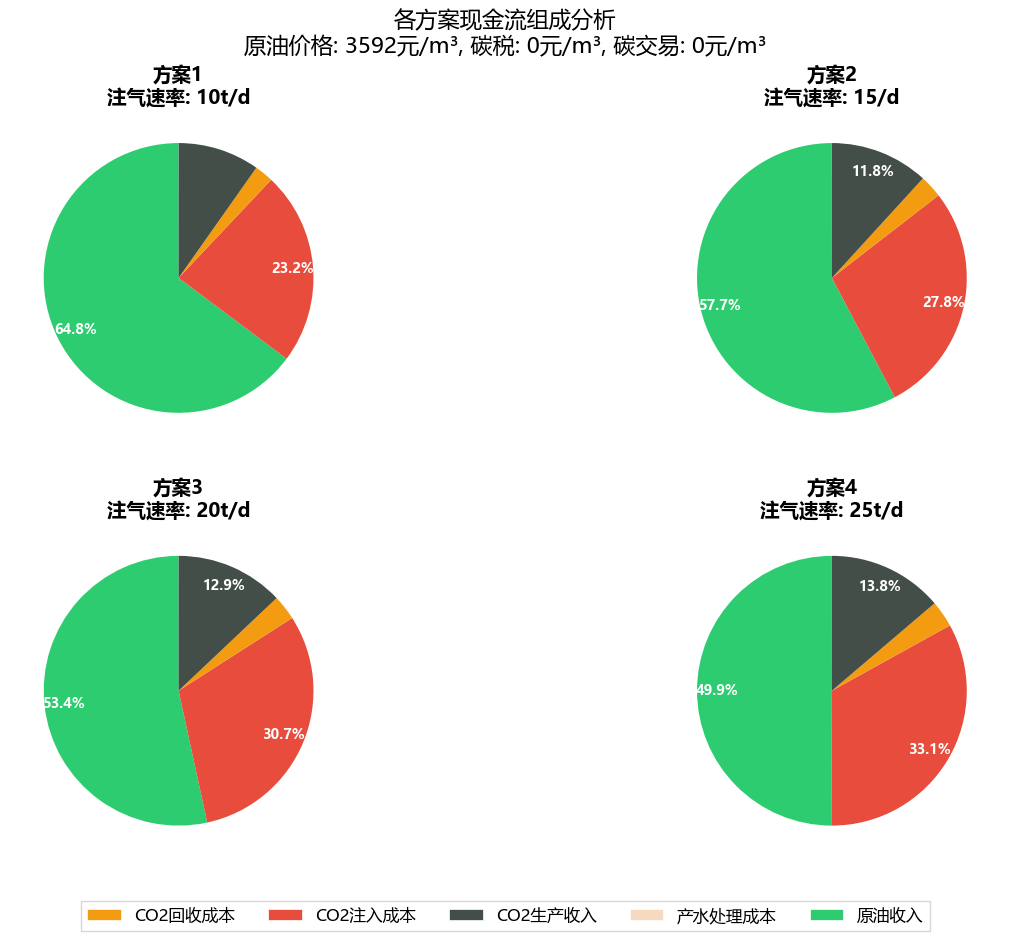

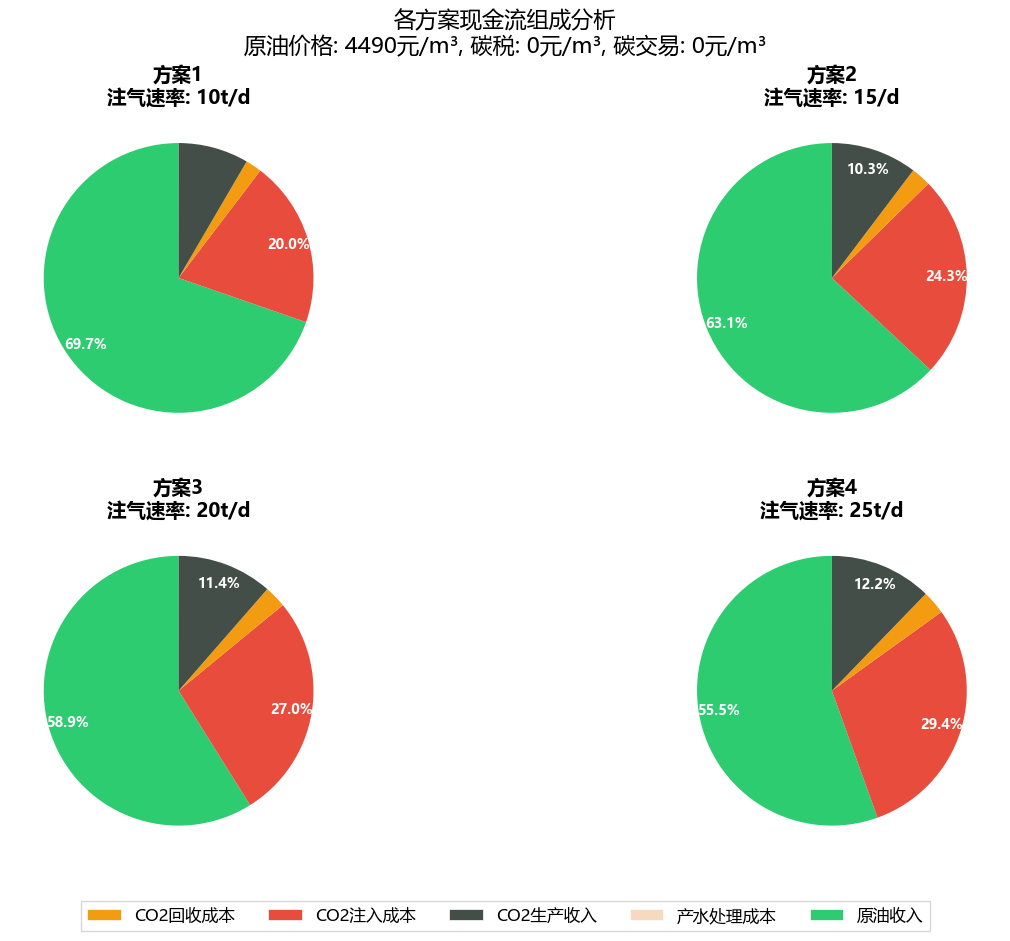

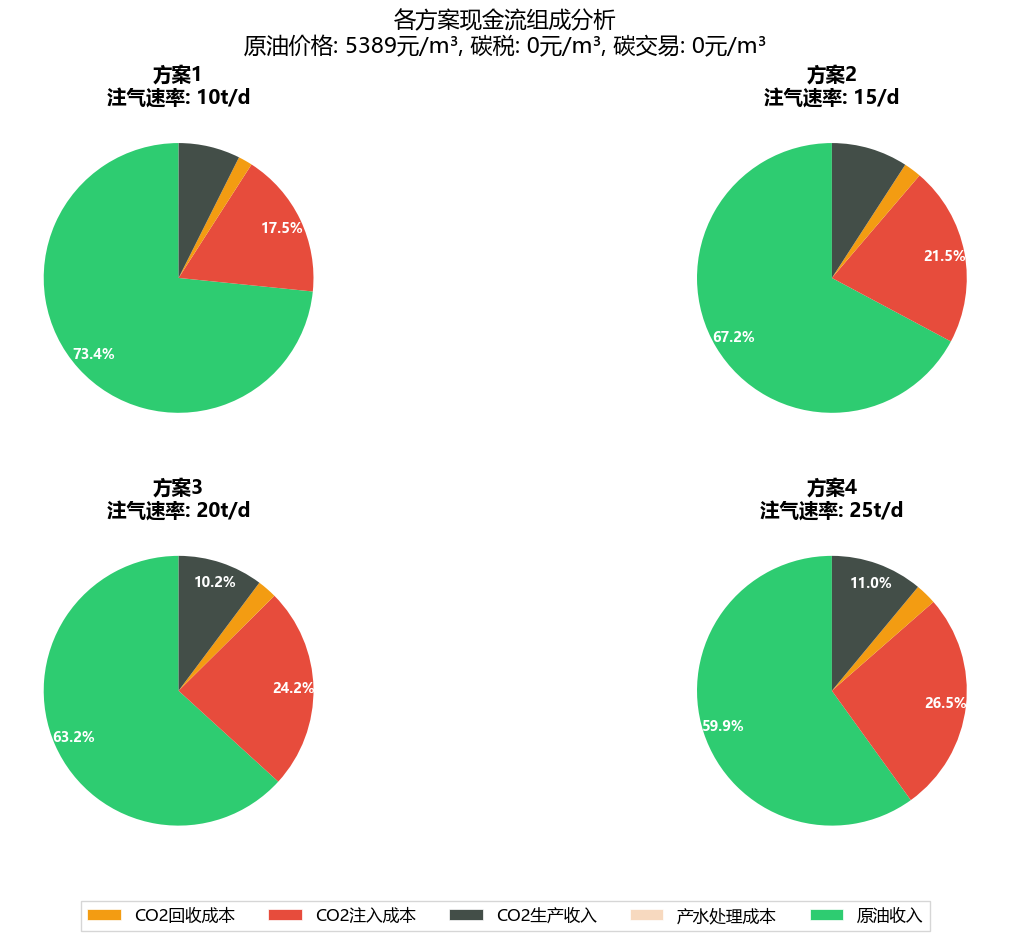

NPV数据已保存到: D:\NEW_DATA\data\BB\Plotting_CO2T_resample_NPV_1.csv


In [4]:
# 0716, 敏感性分析，BB连续注入
cal_npv_from_excel(
    r'D:\NEW_DATA\data\BB\Plotting_CO2T_resample.xlsx', 
    r'D:\NEW_DATA\data\BB\Plotting_CO2T_resample_NPV_1.csv',
    fig_title = '1各方案下协同指数和NPV对比',
    n_cols = 2, 
    n_rows = 2,
    r_CO2 = 0.65, 
    Limit2 = 10000000, 
    ro = [2245, 2694, 3144, 3592, 4490, 5389], 
    TRADE_CO2 = [0, 0, 0, 0, 0, 0],
    TAX_CO2 = [0, 0, 0, 0, 0, 0], 
    r_CO2_i = 1.2, 
    SUB_CO2 = 0,
    x_labels = ['10t/d', '15/d','20t/d', '25t/d'], 
    x_axis_name = '注气速率',
    show_legend = True
)  

In [ ]:
# 白豹NPV
cal_npv_from_excel(
    r'D:\NEW_DATA\data\BB\Plotting_CO2T_resample.xlsx', 
    r'D:\NEW_DATA\data\BB\Plotting_CO2T_resample_NPV.csv',
    fig_title = '1各方案下协同指数和NPV对比',
    n_cols = 2, 
    n_rows = 2,
    r_CO2 = 0.65, 
    Limit2 = 10000000, 
    ro = [3144, 5389, 3144, 3144,5389], 
    TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
    TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
    r_CO2_i = 1.2, 
    SUB_CO2 = 0,
    x_labels = ['10t/d', '15/d','20t/d', '25t/d'], 
    x_axis_name = '注气速率',

)  
cal_npv_from_excel(
    r'D:\NEW_DATA\data\BB\Plotting_TWAG_resample.xlsx', 
    r'D:\NEW_DATA\data\BB\Plotting_TWAG_resample_NPV.csv',
    fig_title = '1各方案下协同指数和NPV对比',
    n_cols = 2, 
    n_rows = 2,
    r_CO2 = 0.65, 
    Limit2 = 10000000, 
    ro = [3144, 5389, 3144, 3144,5389], 
    TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
    TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
    r_CO2_i = 1.2, 
    SUB_CO2 = 0,
    x_labels = ['10t/d', '15/d','20t/d', '25t/d'], 
    x_axis_name = '注气速率',
)  
cal_npv_from_excel(
    r'D:\NEW_DATA\data\BB\Plotting_WAGG_resample.xlsx', 
    r'D:\NEW_DATA\data\BB\Plotting_WAGG_resample_NPV.csv',
    fig_title = '1各方案下协同指数和NPV对比',
    n_cols = 3, 
    n_rows = 2,
    r_CO2 = 0.65, 
    Limit2 = 10000000, 
    ro = [3144, 5389, 3144, 3144,5389], 
    TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
    TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
    r_CO2_i = 1.2, 
    SUB_CO2 = 0,
    x_labels = ['1m', '2m', '3m', '4m', '6m'], 
    x_axis_name = '注气周期' ,
)  
cal_npv_from_excel(
    r'D:\NEW_DATA\data\BB\Plotting_WAGW_resample.xlsx', 
    r'D:\NEW_DATA\data\BB\Plotting_WAGW_resample_NPV.csv',
    fig_title = '1各方案下协同指数和NPV对比',
    n_cols = 3, 
    n_rows = 2,
    r_CO2 = 0.65, 
    Limit2 = 10000000, 
    ro = [3144, 5389, 3144, 3144,5389], 
    TRADE_CO2 = [0, 0, 0.182, 0.182, 0.182],
    TAX_CO2 = [0, 0, 0.14, 0.28, 0.14], 
    r_CO2_i = 1.2, 
    SUB_CO2 = 0,
    x_labels = ['1m', '2m', '3m', '4m', '6m'], 
    x_axis_name = '注水周期' ,
)  

In [ ]:
# 0620 增加了保留单个输出的月数据
# 输出的全部属性进行 resampling，如果IX没有设置按月输出，那么会根据收敛时间步输出，一是导致时间混乱、二是数据行巨大，后期读取和处理数据耗时长。这里将按照按月插值成标准的数据
import pandas as pd
import numpy as np
import warnings
from functools import lru_cache
import re
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

yunlv = ["PosNeg", "NegPos", "Pos", "Neg", "base", "diff"]

def extract_number(name):
    try:
        return int(name.split('_')[-1])
    except ValueError:
        try:
            return int(name.split('diff')[-1])
        except ValueError:
            for idx, value in enumerate(yunlv):
                parts = re.split(r'[_\s-]', name)
                if value in parts:
                    return 100000 + idx
            return float('inf')

@lru_cache(maxsize=1)
def get_attr_raw_data(df_path): # Removed attributes_to_get_tuple
    print(f"Attempting to read Excel file: {df_path}")
    df = None
    try:
        df = pd.read_excel(df_path, header=None)
        print(f"Successfully read Excel file. Shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: File not found at {df_path}")
        return {}, []
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return {}, []

    if df is None:
        return {}, []

    original_case_names = []
    case_name_col_indices = []
    case_names_row_index = 2
    first_case_col_index = 1

    try:
        if case_names_row_index < len(df):
            case_names_row = df.iloc[case_names_row_index]
            for i in range(first_case_col_index, len(case_names_row)):
                 if pd.notna(case_names_row[i]):
                      case_name_col_indices.append(i)
                      original_case_names.append(str(case_names_row[i]).strip())
            print(f"Extracted {len(original_case_names)} original case names from row {case_names_row_index+1}: {list(zip(original_case_names, case_name_col_indices))}")
        else:
             print(f"Warning: Case names row {case_names_row_index+1} not found in the DataFrame. Cannot extract case names.")
    except Exception as e:
        print(f"Error extracting original case names from row {case_names_row_index+1}: {e}")
        return {}, []

    attribute_raw_data = {}
    current_attr = None
    start_row = None
    # attributes_to_get is no longer used here as we want all attributes

    for i in range(len(df)):
        row = df.iloc[i]
        if pd.notna(row[0]) and isinstance(row[0], str) and ',' in row[0]:
            try:
                attr_name_raw = str(row[0])
                attr_name_parts = attr_name_raw.split(',', 1)
                attr_name = attr_name_parts[1].strip() if len(attr_name_parts) > 1 else attr_name_parts[0].strip()

                # Process the previous attribute block if one was identified
                if current_attr is not None and start_row is not None: # No longer checking against attributes_to_get
                    data_start_row = start_row + 4
                    data_end_row = i

                    if data_start_row < data_end_row:
                        cols_to_extract = [0] + case_name_col_indices
                        valid_cols_to_extract = [col for col in cols_to_extract if col < df.shape[1]]
                        if not valid_cols_to_extract:
                            print(f"  Warning: No valid columns found for attribute '{current_attr}'. Skipping.")
                        else:
                            raw_slice = df.iloc[data_start_row : data_end_row, valid_cols_to_extract]
                            if len(raw_slice.columns) == len(original_case_names) + 1:
                                raw_slice.columns = ['Date'] + original_case_names
                                attribute_raw_data[current_attr] = raw_slice.copy()
                                print(f"  Extracted raw data for '{current_attr}'. Shape: {raw_slice.shape}")
                            else:
                                print(f"  Warning: Column count mismatch for '{current_attr}'. Expected {len(original_case_names) + 1}, got {len(raw_slice.columns)}.")
                    else:
                        print(f"  Warning: No data rows found for attribute '{current_attr}'.")

                current_attr = attr_name
                start_row = i
            except Exception as e:
                print(f"Error processing potential attribute header row {i}: {e}")

    # Process the last attribute block
    if current_attr is not None and start_row is not None: # No longer checking against attributes_to_get
        data_start_row = start_row + 4
        if data_start_row < len(df):
            cols_to_extract = [0] + case_name_col_indices
            valid_cols_to_extract = [col for col in cols_to_extract if col < df.shape[1]]
            if not valid_cols_to_extract:
                print(f"  Warning: No valid columns found for last attribute '{current_attr}'. Skipping.")
            else:
                raw_slice = df.iloc[data_start_row : , valid_cols_to_extract]
                if len(raw_slice.columns) == len(original_case_names) + 1:
                    raw_slice.columns = ['Date'] + original_case_names
                    attribute_raw_data[current_attr] = raw_slice.copy()
                    print(f"  Extracted raw data for last attribute '{current_attr}'. Shape: {raw_slice.shape}")
                else:
                    print(f"  Warning: Column count mismatch for last attribute '{current_attr}'. Expected {len(original_case_names) + 1}, got {len(raw_slice.columns)}.")
        else:
            print(f"  Warning: No data rows found for last attribute '{current_attr}'.")

    print("Finished raw data extraction.")
    return attribute_raw_data, original_case_names


def smart_resample_data(df_raw, start_date_str, total_years):
    """
    智能重采样函数：
    1. 某年有多条（多个月份）全部保留
    2. 某年只有一条只保留这一条
    3. 删除多余的数据
    4. 确保输出包含所有目标年份的数据
    """
    print(f"  Original data shape: {df_raw.shape}")
    
    # 转换日期列
    df_raw['Date'] = pd.to_datetime(df_raw['Date'], errors='coerce')
    df_raw.dropna(subset=['Date'], inplace=True)
    
    if df_raw.empty:
        print(f"  Warning: No valid dates found. Skipping resampling.")
        return pd.DataFrame()
    
    df_raw.set_index('Date', inplace=True)
    df_raw = df_raw.apply(pd.to_numeric, errors='coerce').sort_index()
    
    # 根据start_date_str和total_years生成目标年份列表
    base_start_date = pd.to_datetime(start_date_str)
    target_years = [base_start_date.year + i for i in range(total_years)]
    print(f"  Target years based on start_date={start_date_str} and total_years={total_years}: {target_years}")
    
    # 获取原始数据中的年份列表
    data_years = df_raw.index.year.unique()
    data_years = sorted(data_years)
    print(f"  Found years in data: {data_years}")
    
    # 检查每个年份的数据并处理
    resampled_data = []
    
    for year in target_years:
        year_data = df_raw[df_raw.index.year == year]
        
        if year_data.empty:
            # 目标年份没有数据，跳过
            print(f"    Year {year}: No data found, skipping")
            continue
        
        if len(year_data) > 1:
            # 有多条（多个月份）全部保留
            print(f"    Year {year}: 多条数据（{len(year_data)}），全部保留")
            resampled_data.append(year_data)
        else:
            # 只有一条，保留这一条
            print(f"    Year {year}: 只有一条，保留")
            resampled_data.append(year_data)
    
    if resampled_data:
        result = pd.concat(resampled_data)
        print(f"  Final resampled data shape: {result.shape}")
        return result
    else:
        print(f"  No data to resample")
        return pd.DataFrame()


def process_and_resample_excel(input_df_path, output_excel_path, start_date_str="2024/7/4", total_years=20):
    print(f"\n--- Starting data processing and resampling for {input_df_path} ---")

    # Call get_attr_raw_data without specifying attributes, so it extracts all
    raw_attribute_data, original_case_names = get_attr_raw_data(input_df_path)

    if not raw_attribute_data or not original_case_names:
        print("Error: No data or case names extracted. Cannot proceed with resampling.")
        return

    # Sort attributes by their appearance order in the original file
    # This ensures the output maintains the original attribute order
    original_df = pd.read_excel(input_df_path, header=None)
    
    found_attribute_order = []
    for i in range(len(original_df)):
        if pd.notna(original_df.iloc[i, 0]) and isinstance(original_df.iloc[i, 0], str) and ',' in original_df.iloc[i, 0]:
            attr_name_raw = str(original_df.iloc[i, 0])
            attr_name_parts = attr_name_raw.split(',', 1)
            attr_name = attr_name_parts[1].strip() if len(attr_name_parts) > 1 else attr_name_parts[0].strip()
            if attr_name in raw_attribute_data: # Only add if we actually extracted data for it
                found_attribute_order.append(attr_name)


    with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
        current_write_row = 0

        first_attr_header_row = -1
        for i in range(len(original_df)):
            if pd.notna(original_df.iloc[i, 0]) and isinstance(original_df.iloc[i, 0], str) and ',' in original_df.iloc[i, 0]:
                first_attr_header_row = i
                break

        if first_attr_header_row > 0:
            original_df.iloc[:first_attr_header_row].to_excel(writer, sheet_name='Sheet1', index=False, header=False)
            current_write_row = first_attr_header_row
        else:
            original_df.iloc[:4].to_excel(writer, sheet_name='Sheet1', index=False, header=False)
            current_write_row = 4


        for attr_name in found_attribute_order: # Iterate through all found attributes in their original order
            if attr_name in raw_attribute_data and not raw_attribute_data[attr_name].empty:
                df_raw = raw_attribute_data[attr_name].copy()
                print(f"Processing attribute: '{attr_name}' with raw data shape: {df_raw.shape}")

                # 使用新的智能重采样函数
                resampled_df = smart_resample_data(df_raw, start_date_str, total_years)
                
                if resampled_df.empty:
                    print(f"  Warning: No valid resampled data for attribute '{attr_name}'. Skipping.")
                    continue

                print(f"  Resampled data shape for '{attr_name}': {resampled_df.shape}")

                block_start_row = -1
                for i in range(len(original_df)):
                    if pd.notna(original_df.iloc[i, 0]) and isinstance(original_df.iloc[i, 0], str) and f"Field, {attr_name}" in original_df.iloc[i, 0]:
                        block_start_row = i
                        break
                
                if block_start_row != -1:
                    rows_to_copy = []
                    if block_start_row < len(original_df):
                        rows_to_copy.append(block_start_row)
                    if block_start_row + 1 < len(original_df):
                        rows_to_copy.append(block_start_row + 1)
                    if block_start_row + 2 < len(original_df):
                        rows_to_copy.append(block_start_row + 2)
                    if block_start_row + 3 < len(original_df):
                        rows_to_copy.append(block_start_row + 3)

                    if rows_to_copy:
                        original_df.iloc[rows_to_copy].to_excel(writer, sheet_name='Sheet1', startrow=current_write_row, index=False, header=False)
                        current_write_row += len(rows_to_copy)

                df_to_write = resampled_df.reset_index(names=['Date'])
                df_to_write['Date'] = df_to_write['Date'].dt.strftime('%Y/%#m/%#d')

                df_to_write.to_excel(writer, sheet_name='Sheet1', startrow=current_write_row, index=False, header=False)
                current_write_row += df_to_write.shape[0]

                empty_rows_df = pd.DataFrame(index=range(3), columns=range(df_to_write.shape[1]))
                empty_rows_df.to_excel(writer, sheet_name='Sheet1', startrow=current_write_row, index=False, header=False)
                current_write_row += empty_rows_df.shape[0]

            else:
                print(f"Warning: No raw data found for attribute '{attr_name}'. Skipping.")

    print(f"--- Data processing and resampling complete. Output saved to {output_excel_path} ---")


replacement_dict = {
    'PosNeg': '正负相间',
    'NegPos': '负正相间',
    'Pos': '正向',
    'Neg': '负向',
    'base': '基础方案',
    'diff': '差值方案',
    '_': ' '
}


get_attr_raw_data.cache_clear()

# input_excel_path = r'D:\NEW_DATA\data\BB\Plotting_CO2T.xlsx'
# output_excel_path = r'D:\NEW_DATA\data\BB\Plotting_CO2T_resample.xlsx'

# output_excel_path = r'D:\NEW_DATA\Models\化子坪\注气速率.xlsx'
input_excel_path = r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE.xlsx'
output_excel_path = r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE_resample.xlsx'
input_excel_path = r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_PERIOD.xlsx'
output_excel_path = r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_PERIODE_resample.xlsx'
input_excel_path = r'D:\NEW_DATA\data\HZP\HZP_WAG_WINJ_PERIOD.xlsx'
output_excel_path = r'D:\NEW_DATA\data\HZP\HZP_WAG_WINJ_PERIODE_resample.xlsx'
input_excel_path = r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE.xlsx'
output_excel_path = r'D:\NEW_DATA\data\HZP\HZP_WAG_GINJ_RATE_resample.xlsx'
input_excel_path = r'D:\NEW_DATA\data\HZP\HZP_连续注气.xlsx'
output_excel_path = r'D:\NEW_DATA\data\HZP\HZP_连续注气_resample.xlsx'

input_excel_path = r'D:\NEW_DATA\Models\1. 机理模型\渗透率-raw.xlsx'
output_excel_path = r'D:\NEW_DATA\Models\1. 机理模型\渗透率_resample.xlsx'
process_and_resample_excel(input_excel_path, output_excel_path, start_date_str="2004/1/1", total_years=21)

# process_and_resample_excel(input_excel_path, output_excel_path, start_date_str="2024/8/1", total_years=21)
# 清理空行
df = pd.read_excel(output_excel_path)

# 删除所有空行
df_cleaned = df.dropna(how='all')

df_cleaned.to_excel(output_excel_path, index=False)

In [ ]:
# 进行上一步数据处理后，可能存在空行，删去它们
import pandas as pd

# 读取Excel文件
file_path = r'D:\NEW_DATA\data\HZP\Plotting_0001_resampled.xlsx'
df = pd.read_excel(file_path)

# 删除所有空行
df_cleaned = df.dropna(how='all')

df_cleaned.to_excel(r'D:\NEW_DATA\data\HZP\Plotting_0001_resampled_c.xlsx', index=False)

In [ ]:
# 部分属性 resampling - 未使用
import pandas as pd
import numpy as np
import warnings
from functools import lru_cache
import re
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

yunlv = ["PosNeg", "NegPos", "Pos", "Neg", "base", "diff"]

def extract_number(name):
    try:
        return int(name.split('_')[-1])
    except ValueError:
        try:
            return int(name.split('diff')[-1])
        except ValueError:
            for idx, value in enumerate(yunlv):
                parts = re.split(r'[_\s-]', name)
                if value in parts:
                    return 100000 + idx
            return float('inf')

@lru_cache(maxsize=1)
def get_attr_raw_data(df_path, attributes_to_get_tuple):
    print(f"Attempting to read Excel file: {df_path}")
    df = None
    try:
        df = pd.read_excel(df_path, header=None)
        print(f"Successfully read Excel file. Shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: File not found at {df_path}")
        return {}, []
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return {}, []

    if df is None:
        return {}, []

    original_case_names = []
    case_name_col_indices = []
    case_names_row_index = 2
    first_case_col_index = 1

    try:
        if case_names_row_index < len(df):
            case_names_row = df.iloc[case_names_row_index]
            for i in range(first_case_col_index, len(case_names_row)):
                 if pd.notna(case_names_row[i]):
                      case_name_col_indices.append(i)
                      original_case_names.append(str(case_names_row[i]).strip())
            print(f"Extracted {len(original_case_names)} original case names from row {case_names_row_index+1}: {list(zip(original_case_names, case_name_col_indices))}")
        else:
             print(f"Warning: Case names row {case_names_row_index+1} not found in the DataFrame. Cannot extract case names.")
    except Exception as e:
        print(f"Error extracting original case names from row {case_names_row_index+1}: {e}")
        return {}, []

    attribute_raw_data = {}
    current_attr = None
    start_row = None
    attributes_to_get = set(attributes_to_get_tuple)

    for i in range(len(df)):
        row = df.iloc[i]
        if pd.notna(row[0]) and isinstance(row[0], str) and ',' in row[0]:
            try:
                attr_name_raw = str(row[0])
                attr_name_parts = attr_name_raw.split(',', 1)
                attr_name = attr_name_parts[1].strip() if len(attr_name_parts) > 1 else attr_name_parts[0].strip()

                if current_attr is not None and start_row is not None and current_attr in attributes_to_get:
                    data_start_row = start_row + 4
                    data_end_row = i

                    if data_start_row < data_end_row:
                        cols_to_extract = [0] + case_name_col_indices
                        valid_cols_to_extract = [col for col in cols_to_extract if col < df.shape[1]]
                        if not valid_cols_to_extract:
                            print(f"  Warning: No valid columns found for attribute '{current_attr}'. Skipping.")
                        else:
                            raw_slice = df.iloc[data_start_row : data_end_row, valid_cols_to_extract]
                            if len(raw_slice.columns) == len(original_case_names) + 1:
                                raw_slice.columns = ['Date'] + original_case_names
                                attribute_raw_data[current_attr] = raw_slice.copy()
                                print(f"  Extracted raw data for '{current_attr}'. Shape: {raw_slice.shape}")
                            else:
                                print(f"  Warning: Column count mismatch for '{current_attr}'. Expected {len(original_case_names) + 1}, got {len(raw_slice.columns)}.")
                    else:
                        print(f"  Warning: No data rows found for attribute '{current_attr}'.")

                current_attr = attr_name
                start_row = i
            except Exception as e:
                print(f"Error processing potential attribute header row {i}: {e}")

    if current_attr is not None and start_row is not None and current_attr in attributes_to_get:
        data_start_row = start_row + 4
        if data_start_row < len(df):
            cols_to_extract = [0] + case_name_col_indices
            valid_cols_to_extract = [col for col in cols_to_extract if col < df.shape[1]]
            if not valid_cols_to_extract:
                print(f"  Warning: No valid columns found for last attribute '{current_attr}'. Skipping.")
            else:
                raw_slice = df.iloc[data_start_row : , valid_cols_to_extract]
                if len(raw_slice.columns) == len(original_case_names) + 1:
                    raw_slice.columns = ['Date'] + original_case_names
                    attribute_raw_data[current_attr] = raw_slice.copy()
                    print(f"  Extracted raw data for last attribute '{current_attr}'. Shape: {raw_slice.shape}")
                else:
                    print(f"  Warning: Column count mismatch for last attribute '{current_attr}'. Expected {len(original_case_names) + 1}, got {len(raw_slice.columns)}.")
        else:
            print(f"  Warning: No data rows found for last attribute '{current_attr}'.")

    print("Finished raw data extraction.")
    return attribute_raw_data, original_case_names

def process_and_resample_excel(input_df_path, output_excel_path, start_date_str="2024/7/4", total_years=20):
    print(f"\n--- Starting data processing and resampling for {input_df_path} ---")

    attributes_to_process_tuple = (
        'Oil production cumulative',
        'Gas injection cumulative',
        'Gas production cumulative',
        'Water injection cumulative',
        'Water production cumulative',
        'Tracer production cumulative',
        'Tracer injection cumulative',
    )

    raw_attribute_data, original_case_names = get_attr_raw_data(input_df_path, attributes_to_process_tuple)

    if not raw_attribute_data or not original_case_names:
        print("Error: No data or case names extracted. Cannot proceed with resampling.")
        return

    with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
        original_df = pd.read_excel(input_df_path, header=None)

        current_write_row = 0

        for attr_name in attributes_to_process_tuple:
            if attr_name in raw_attribute_data and not raw_attribute_data[attr_name].empty:
                df_raw = raw_attribute_data[attr_name].copy()
                print(f"Processing attribute: '{attr_name}' with raw data shape: {df_raw.shape}")

                df_raw['Date'] = pd.to_datetime(df_raw['Date'], errors='coerce')
                df_raw.dropna(subset=['Date'], inplace=True)

                if df_raw.empty:
                    print(f"  Warning: No valid dates found for attribute '{attr_name}'. Skipping resampling.")
                    continue

                df_raw.set_index('Date', inplace=True)
                df_raw = df_raw.apply(pd.to_numeric, errors='coerce').sort_index()

                base_start_date = pd.to_datetime(start_date_str)
                yearly_dates = [base_start_date + pd.DateOffset(years=i) for i in range(total_years)]
                target_index = pd.DatetimeIndex(yearly_dates)
                
                # Full resampling with interpolation
                resampled_df = df_raw.reindex(df_raw.index.union(target_index)).interpolate(method='linear', limit_direction='both')
                resampled_df = resampled_df.reindex(target_index)

                # For cumulative data, if the first value is NaN after interpolation, set it to 0
                # And for any NaNs that might remain (e.g., if target index is outside original data range entirely), fill with 0
                resampled_df = resampled_df.fillna(0)
                
                print(f"  Resampled and interpolated data shape for '{attr_name}': {resampled_df.shape}")

                # --- Write attribute header and then data ---
                # Get the original header rows for this attribute block
                # Scan original_df to find the rows corresponding to this attribute's block
                # We need the "Field, Attribute", "X Y1...", "Date Col1...", and "Unit Col1..." rows
                
                block_start_row = -1
                block_end_row = -1 # This will be the row *before* the next attribute or end of file
                
                for i in range(len(original_df)):
                    if pd.notna(original_df.iloc[i, 0]) and isinstance(original_df.iloc[i, 0], str) and f"Field, {attr_name}" in original_df.iloc[i, 0]:
                        block_start_row = i
                        break
                
                if block_start_row != -1:
                    # Find where the next attribute block starts or end of file
                    for i in range(block_start_row + 1, len(original_df)):
                        if pd.notna(original_df.iloc[i, 0]) and isinstance(original_df.iloc[i, 0], str) and ',' in original_df.iloc[i, 0]:
                            block_end_row = i
                            break
                    if block_end_row == -1: # It's the last attribute
                        block_end_row = len(original_df)
                    
                    # Copy the attribute header (Field, Attribute), X/Y, Date/Scenario, and Units row
                    # These are typically block_start_row, block_start_row+1, block_start_row+2, block_start_row+3
                    
                    # Ensure we don't go out of bounds for the original_df
                    rows_to_copy = []
                    if block_start_row < len(original_df):
                        rows_to_copy.append(block_start_row)
                    if block_start_row + 1 < len(original_df):
                        rows_to_copy.append(block_start_row + 1)
                    if block_start_row + 2 < len(original_df):
                        rows_to_copy.append(block_start_row + 2)
                    if block_start_row + 3 < len(original_df):
                        rows_to_copy.append(block_start_row + 3)

                    if rows_to_copy:
                        original_df.iloc[rows_to_copy].to_excel(writer, sheet_name='Sheet1', startrow=current_write_row, index=False, header=False)
                        current_write_row += len(rows_to_copy)

                df_to_write = resampled_df.reset_index(names=['Date'])
                df_to_write['Date'] = df_to_write['Date'].dt.strftime('%Y/%#m/%#d')

                df_to_write.to_excel(writer, sheet_name='Sheet1', startrow=current_write_row, index=False, header=False)
                current_write_row += df_to_write.shape[0]

                empty_rows_df = pd.DataFrame(index=range(3), columns=range(df_to_write.shape[1]))
                empty_rows_df.to_excel(writer, sheet_name='Sheet1', startrow=current_write_row, index=False, header=False)
                current_write_row += empty_rows_df.shape[0]

            else:
                print(f"Warning: No raw data found for attribute '{attr_name}'. Skipping.")

    print(f"--- Data processing and resampling complete. Output saved to {output_excel_path} ---")

get_attr_raw_data.cache_clear()

input_excel_path = r'D:\NEW_DATA\data\HZP\Plotting_0001.xlsx'
output_excel_path = r'D:\NEW_DATA\data\HZP\Plotting_0001_resampled.xlsx'

process_and_resample_excel(input_excel_path, output_excel_path, start_date_str="2024/7/4", total_years=20)



--- Starting data processing and resampling for D:\NEW_DATA\data\HZP\Plotting_0001.xlsx ---
Attempting to read Excel file: D:\NEW_DATA\data\HZP\Plotting_0001.xlsx
Successfully read Excel file. Shape: (129513, 7)
Extracted 6 original case names from row 3: [('BEST_FIT_IMM_RESTART_1', 1), ('BEST_FIT_IMM_RESTART_2', 2), ('BEST_FIT_IMM_RESTART_3', 3), ('BEST_FIT_IMM_RESTART_4', 4), ('BEST_FIT_IMM_RESTART_5', 5), ('BEST_FIT_IMM_RESTART_6', 6)]
  Extracted raw data for 'Tracer injection cumulative'. Shape: (4462, 7)
  Extracted raw data for 'Tracer production cumulative'. Shape: (4462, 7)
  Extracted raw data for 'Gas injection cumulative'. Shape: (4462, 7)
  Extracted raw data for 'Gas production cumulative'. Shape: (4462, 7)
  Extracted raw data for 'Oil production cumulative'. Shape: (4462, 7)
  Extracted raw data for 'Water injection cumulative'. Shape: (4462, 7)
  Extracted raw data for 'Water production cumulative'. Shape: (4462, 7)
Finished raw data extraction.
Processing attribute: 